<a href="https://colab.research.google.com/github/Tasenko03/nlp_project/blob/main/Clustering_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import gdown
import io
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from collections import Counter
import string
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
from nltk.corpus import wordnet

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [ ]:
from gensim.models import Word2Vec, FastText
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist, squareform

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import spacy
from spacy.lang.ru.stop_words import STOP_WORDS as ru_stopwords
from spacy.lang.en.stop_words import STOP_WORDS as en_stopwords

In [ ]:
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 22.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
url = "https://drive.google.com/drive/folders/138Mv-hhvm2e0tTODEomQiUt8CVBOA1mX?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/project data/ria_news.csv',
 '/content/project data/vk_comments.tsv',
 '/content/project data/vk_news.tsv']

In [ ]:
content = files.upload()

Saving vk_news.tsv to vk_news.tsv


In [ ]:
file_path = io.BytesIO(content['vk_news.tsv'])
vk_news = pd.read_csv(file_path, sep='\t', header=0)

In [ ]:
vk_news.head(5)

,id,href,datetime,title,text,likes,comments
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",NaN,32,42
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",NaN,84,23
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,NaN,58,35
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,NaN,45,145


# EDA VK News

In [ ]:
vk_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19928 entries, 0 to 19927
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        19928 non-null  int64 
 1   href      19928 non-null  object
 2   datetime  19928 non-null  object
 3   title     19928 non-null  object
 4   text      6525 non-null   object
 5   likes     19928 non-null  int64 
 6   comments  19928 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 1.1+ MB


In [ ]:
vk_news.isna().sum()

id              0
href            0
datetime        0
title           0
text        13403
likes           0
comments        0
dtype: int64

В колонке text есть пропущенные значения

In [ ]:
duplicateRows = vk_news[vk_news.duplicated()]
duplicateRows

,id,href,datetime,title,text,likes,comments


В датасете нет дубликатов, все новости являются уникальными

In [ ]:
vk_news['date'] = pd.to_datetime(vk_news['datetime']).dt.date
vk_news['time'] = pd.to_datetime(vk_news['datetime']).dt.time

# Удаляем оригинальный столбец datetime, если он больше не нужен
vk_news.drop(columns=['datetime'], inplace=True)

# Выводим результат
vk_news.head()

,id,href,title,text,likes,comments,date,time
0,24006362,/20190201/1550280358.html,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28,2019-02-01,23:13:17
1,24006240,/20190201/1550268781.html,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",NaN,32,42,2019-02-01,22:38:41
2,24006100,/20190201/1550282212.html,"В Черном море нашли ""потерянный флот Гитлера""",NaN,84,23,2019-02-01,21:58:52
3,24005972,/20190202/1550283179.html,В США освободили задержанную российскую актрис...,NaN,58,35,2019-02-01,21:27:06
4,24005764,/20190201/1550262848.html,Толкнувший Скабееву депутат Рады заявил о гроз...,NaN,45,145,2019-02-01,20:55:54


В таблице vk_news.tsv лежат данные о новостях, которые РИА запостили ВКонтакте с 2017 по 2019.

* id - уникальный идентификатор поста
* href - ссылка на сайт (если она была указана в посте)
* datetime - дата и время публикации новости
* title - заголовок новости
* likes - число лайков под постом
* comments - число комментариев под постом

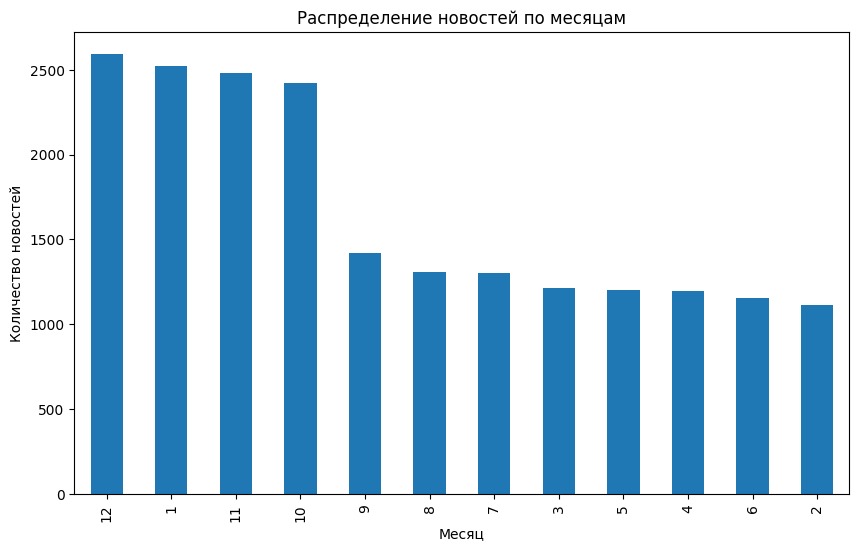

In [ ]:
# Преобразование даты и времени в формат datetime
vk_news["date"] = pd.to_datetime(vk_news['date'], format='%Y-%m-%d')

# Гистограмма распределения новостей по месяцам
plt.figure(figsize=(10, 6))
vk_news["date"].dt.month.value_counts().plot(kind="bar")
plt.title("Распределение новостей по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Количество новостей")
plt.show()

# Preprocessing texts:

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('russian'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
nlp = spacy.load('ru_core_news_sm')

In [ ]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation and word !='"' and word !='``']
    return ' '.join(tokens)

In [ ]:
vk_news['preproced_title'] = vk_news['title'].apply(preprocess_text)

In [ ]:
vk_news.head()

,id,href,title,text,likes,comments,date,time,preproced_title,vector_w2v
0,24006362,/20190201/1550280358.html,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28,2019-02-01,23:13:17,днр заявили задержании диверсантов причастных ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,24006240,/20190201/1550268781.html,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",NaN,32,42,2019-02-01,22:38:41,житель урала заминировал '' тц из-за снятия со...,"[-0.026784008, 0.04596131, 0.026244625, 0.0303..."
2,24006100,/20190201/1550282212.html,"В Черном море нашли ""потерянный флот Гитлера""",NaN,84,23,2019-02-01,21:58:52,черном море нашли потерянный флот гитлера '',"[-0.07443841, 0.11055287, 0.053822767, 0.08105..."
3,24005972,/20190202/1550283179.html,В США освободили задержанную российскую актрис...,NaN,58,35,2019-02-01,21:27:06,сша освободили задержанную российскую актрису ...,"[-0.0024304874, 0.0027163012, -0.0029920712, 0..."
4,24005764,/20190201/1550262848.html,Толкнувший Скабееву депутат Рады заявил о гроз...,NaN,45,145,2019-02-01,20:55:54,толкнувший скабееву депутат рады заявил грозящ...,"[-0.005795799, -0.0008357464, -0.011000597, 0...."


# Vectorising:

### Word2Vec Vectorizer:

In [ ]:
model_w2v = Word2Vec(sentences=vk_news['preproced_title'].apply(lambda x: x.split()).tolist(), vector_size=100, window=5, min_count=1, workers=4)

def get_sentence_vector_w2v(sentence):
    vectors = [model_w2v.wv[word] for word in sentence if word in model_w2v.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)

vk_news['vector_w2v'] = vk_news['preproced_title'].apply(get_sentence_vector_w2v)
X_w2v = np.vstack(vk_news['vector_w2v'])

print("Word2Vec Vectors:")
print(X_w2v)

Word2Vec Vectors:
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.02678401  0.04596131  0.02624463 ... -0.04033442  0.02600289
   0.0247005 ]
 [-0.07443841  0.11055287  0.05382277 ... -0.10110258  0.07092702
   0.05733513]
 ...
 [-0.01077731  0.02366629  0.01103912 ... -0.02233213  0.01482258
   0.01002597]
 [-0.0057958  -0.00083575 -0.0110006  ... -0.00717622 -0.00887506
   0.0083157 ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [ ]:
vk_news.head()

,id,href,title,text,likes,comments,date,time,preproced_title,vector_w2v
0,24006362,/20190201/1550280358.html,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28,2019-02-01,23:13:17,днр заявили задержании диверсантов причастных ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,24006240,/20190201/1550268781.html,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",NaN,32,42,2019-02-01,22:38:41,житель урала заминировал '' тц из-за снятия со...,"[-0.026784008, 0.04596131, 0.026244625, 0.0303..."
2,24006100,/20190201/1550282212.html,"В Черном море нашли ""потерянный флот Гитлера""",NaN,84,23,2019-02-01,21:58:52,черном море нашли потерянный флот гитлера '',"[-0.07443841, 0.11055287, 0.053822767, 0.08105..."
3,24005972,/20190202/1550283179.html,В США освободили задержанную российскую актрис...,NaN,58,35,2019-02-01,21:27:06,сша освободили задержанную российскую актрису ...,"[-0.0024304874, 0.0027163012, -0.0029920712, 0..."
4,24005764,/20190201/1550262848.html,Толкнувший Скабееву депутат Рады заявил о гроз...,NaN,45,145,2019-02-01,20:55:54,толкнувший скабееву депутат рады заявил грозящ...,"[-0.005795799, -0.0008357464, -0.011000597, 0...."


In [ ]:
pca = PCA(n_components=5)
X_w2v_reduced = pca.fit_transform(X_w2v)

print("Размерность после снижения PCA:")
print(X_w2v_reduced)

Размерность после снижения PCA:
[[-4.15393425e-01  1.84927081e-02  2.51072348e-03 -1.63758827e-02
  -3.94067175e-03]
 [-7.92951967e-02  1.30311644e-02  1.86006050e-02  2.42784238e-03
  -4.57890584e-03]
 [ 4.21776351e-01 -2.62771622e-04 -1.70623699e-03 -2.70270624e-03
  -3.96072712e-04]
 ...
 [-2.43299684e-01  2.36227363e-02 -7.44249102e-03 -1.13696774e-03
  -8.62198135e-03]
 [-4.33965329e-01 -2.97079635e-02  2.41518532e-03  4.17846488e-03
   2.28931378e-04]
 [-4.15393425e-01  1.84927081e-02  2.51072348e-03 -1.63758827e-02
  -3.94067175e-03]]


In [ ]:
for i in range(5):
    vk_news[f'PCA_W2V{i+1}'] = X_w2v_reduced[:, i]

In [ ]:
vk_news.head(3)

,id,href,title,text,likes,comments,date,time,preproced_title,vector_w2v,PCA_W2V1,PCA_W2V2,PCA_W2V3,PCA_W2V4,PCA_W2V5
0,24006362,/20190201/1550280358.html,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28,2019-02-01,23:13:17,днр заявили задержании диверсантов причастных ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.415393,0.018493,0.002511,-0.016376,-0.003941
1,24006240,/20190201/1550268781.html,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",NaN,32,42,2019-02-01,22:38:41,житель урала заминировал '' тц из-за снятия со...,"[-0.026784008, 0.04596131, 0.026244625, 0.0303...",-0.079295,0.013031,0.018601,0.002428,-0.004579
2,24006100,/20190201/1550282212.html,"В Черном море нашли ""потерянный флот Гитлера""",NaN,84,23,2019-02-01,21:58:52,черном море нашли потерянный флот гитлера '',"[-0.07443841, 0.11055287, 0.053822767, 0.08105...",0.421776,-0.000263,-0.001706,-0.002703,-0.000396


### Fast Text Vectorizer:

In [ ]:
model_ft = FastText(sentences=vk_news['preproced_title'].apply(lambda x: x.split()).tolist(), vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
def get_sentence_vector_fasttext(sentence):
    vectors = [model_ft.wv[word] for word in sentence if word in model_ft.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)

In [ ]:
vk_news['vector_ft'] = vk_news['preproced_title'].apply(get_sentence_vector_fasttext)
X_ft = np.vstack(vk_news['vector_ft'])

In [ ]:
vk_news.head(3)

,id,href,title,text,likes,comments,date,time,preproced_title,vector_w2v,PCA_W2V1,PCA_W2V2,PCA_W2V3,PCA_W2V4,PCA_W2V5,vector_ft
0,24006362,/20190201/1550280358.html,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28,2019-02-01,23:13:17,днр заявили задержании диверсантов причастных ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.415393,0.018493,0.002511,-0.016376,-0.003941,"[-7.606929e-05, -0.00058498426, 0.00068065675,..."
1,24006240,/20190201/1550268781.html,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",NaN,32,42,2019-02-01,22:38:41,житель урала заминировал '' тц из-за снятия со...,"[-0.026784008, 0.04596131, 0.026244625, 0.0303...",-0.079295,0.013031,0.018601,0.002428,-0.004579,"[-0.007870973, 0.0034842503, 0.006534023, 0.00..."
2,24006100,/20190201/1550282212.html,"В Черном море нашли ""потерянный флот Гитлера""",NaN,84,23,2019-02-01,21:58:52,черном море нашли потерянный флот гитлера '',"[-0.07443841, 0.11055287, 0.053822767, 0.08105...",0.421776,-0.000263,-0.001706,-0.002703,-0.000396,"[-0.00947853, 0.004661638, 0.0063480376, 0.003..."


In [ ]:
pca = PCA(n_components=5)
X_ft_reduced = pca.fit_transform(X_ft)
print("Размерность после снижения PCA:")
print(X_ft_reduced)

Размерность после снижения PCA:
[[-2.7765205e-02  2.7292445e-03 -8.6512492e-04 -7.4078131e-04
   9.1344939e-04]
 [ 7.3680384e-03  2.9671591e-04 -4.6753566e-04 -1.0357988e-03
   1.6703647e-04]
 [ 1.6132928e-02 -3.6020116e-03  8.3348196e-04 -4.2144810e-03
  -2.5697344e-03]
 ...
 [-7.3537896e-03 -2.2412266e-03 -1.1454935e-03 -2.7494796e-03
   2.4276646e-03]
 [-2.5911076e-02 -2.5731693e-03  8.9891109e-04 -9.6127522e-05
   9.8420074e-04]
 [-2.8520400e-02 -3.5714632e-04 -1.8082417e-03  4.8828018e-03
   1.2476749e-03]]


In [ ]:
for i in range(5):
    vk_news[f'PCA_FT{i+1}'] = X_ft_reduced[:, i]

In [ ]:
vk_news.head(3)

,id,href,title,text,likes,comments,date,time,preproced_title,vector_w2v,...,PCA_TFIDF3,PCA_TFIDF4,PCA_TFIDF5,cluster_w2v_kmeans,new_category_kmeans_w2v,PCA_FT1,PCA_FT2,PCA_FT3,PCA_FT4,PCA_FT5
0,24006362,/20190201/1550280358.html,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28,2019-02-01,23:13:17,днр заявили задержании диверсантов причастных ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,0.003842,-0.006473,-0.000864,2,Общество,-0.027765,0.002729,-0.000865,-0.000741,0.000913
1,24006240,/20190201/1550268781.html,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",NaN,32,42,2019-02-01,22:38:41,житель урала заминировал '' тц из-за снятия со...,"[-0.026784008, 0.04596131, 0.026244625, 0.0303...",...,0.041813,-0.037069,0.252656,1,В мире,0.007368,0.000297,-0.000468,-0.001036,0.000167
2,24006100,/20190201/1550282212.html,"В Черном море нашли ""потерянный флот Гитлера""",NaN,84,23,2019-02-01,21:58:52,черном море нашли потерянный флот гитлера '',"[-0.07443841, 0.11055287, 0.053822767, 0.08105...",...,-0.015491,0.001912,-0.004508,3,Внешняя политика,0.016133,-0.003602,0.000833,-0.004214,-0.002570


### TF-IDF Vectorizer:

In [ ]:
vectorizer = TfidfVectorizer()

In [ ]:
tfidf_matrix = vectorizer.fit_transform(vk_news['preproced_title'])
tfidf_vectors = tfidf_matrix.toarray()

In [ ]:
vk_news['vector_tfidf'] = list(tfidf_vectors)

In [ ]:
X_tfidf = np.vstack(vk_news['vector_tfidf'])

In [ ]:
pca = PCA(n_components=5)
X_tfidf_reduced = pca.fit_transform(X_tfidf)
print("Размерность после снижения PCA:")
print(X_tfidf_reduced)

Размерность после снижения PCA:
[[ 0.01009925 -0.01174415  0.00384242 -0.00647312 -0.00086405]
 [ 0.01439257 -0.02559455  0.04181305 -0.03706908  0.2526555 ]
 [ 0.02224326 -0.02154801 -0.01549144  0.00191248 -0.0045082 ]
 ...
 [ 0.02594402 -0.02661069 -0.01929847  0.01197666 -0.01497429]
 [-0.05991375  0.01949445  0.1953719  -0.07660189 -0.05035584]
 [-0.10258283  0.0769629  -0.06597332  0.01174091  0.02292517]]


In [ ]:
for i in range(5):
    vk_news[f'PCA_TFIDF{i+1}'] = X_tfidf_reduced[:, i]

In [ ]:
vk_news.head(3)

,id,href,title,text,likes,comments,date,time,preproced_title,vector_w2v,...,PCA_W2V3,PCA_W2V4,PCA_W2V5,vector_ft,vector_tfidf,PCA_TFIDF1,PCA_TFIDF2,PCA_TFIDF3,PCA_TFIDF4,PCA_TFIDF5
0,24006362,/20190201/1550280358.html,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28,2019-02-01,23:13:17,днр заявили задержании диверсантов причастных ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,0.002511,-0.016376,-0.003941,"[-7.606929e-05, -0.00058498426, 0.00068065675,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.010099,-0.011744,0.003842,-0.006473,-0.000864
1,24006240,/20190201/1550268781.html,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",NaN,32,42,2019-02-01,22:38:41,житель урала заминировал '' тц из-за снятия со...,"[-0.026784008, 0.04596131, 0.026244625, 0.0303...",...,0.018601,0.002428,-0.004579,"[-0.007870973, 0.0034842503, 0.006534023, 0.00...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.014393,-0.025595,0.041813,-0.037069,0.252656
2,24006100,/20190201/1550282212.html,"В Черном море нашли ""потерянный флот Гитлера""",NaN,84,23,2019-02-01,21:58:52,черном море нашли потерянный флот гитлера '',"[-0.07443841, 0.11055287, 0.053822767, 0.08105...",...,-0.001706,-0.002703,-0.000396,"[-0.00947853, 0.004661638, 0.0063480376, 0.003...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.022243,-0.021548,-0.015491,0.001912,-0.004508


------------------------------

# K-Means Clustering

### Clustering with Word2Vec Vectors:

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

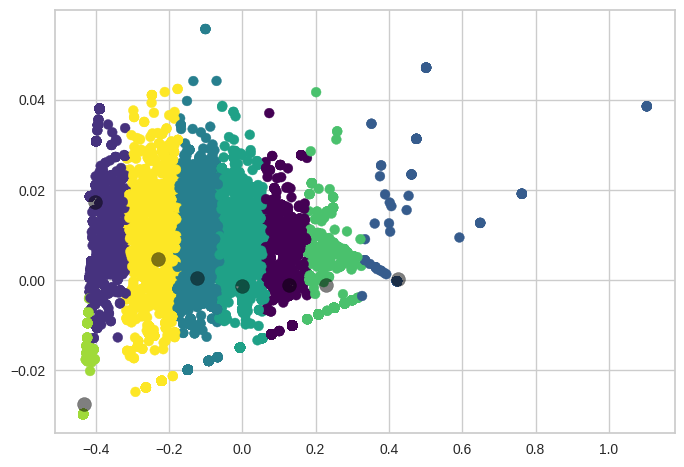

In [ ]:
vectors = vk_news[['PCA_W2V1', 'PCA_W2V2', 'PCA_W2V3', 'PCA_W2V4', 'PCA_W2V5']].to_numpy()

kmeans = KMeans(random_state=42)

y_kmeans = kmeans.fit_predict(vectors)

plt.scatter(vectors[:, 0], vectors[:, 1], s=50, c=y_kmeans, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='black', alpha=0.5)
plt.show()

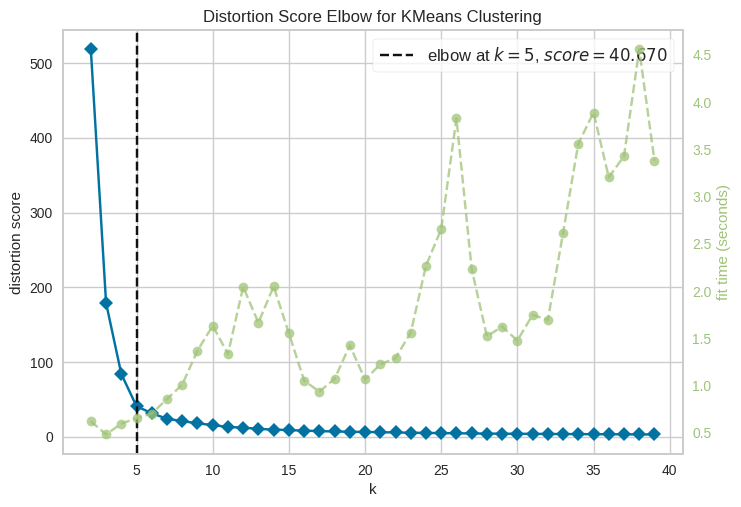

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
vis = KElbowVisualizer(kmeans, k=(2,40))
vis.fit(X_w2v_reduced)
vis.show()

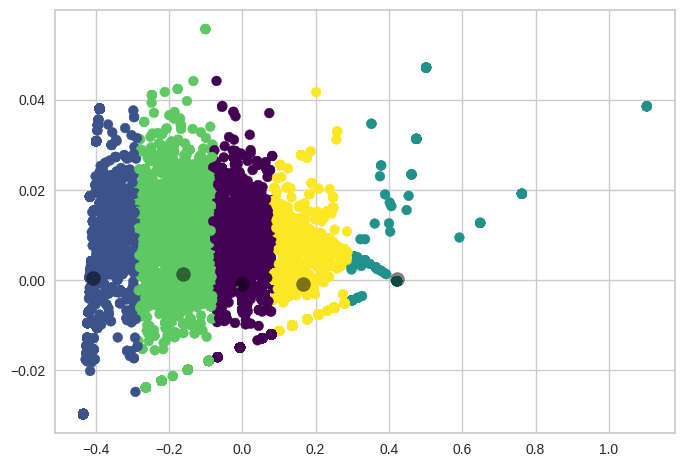

In [ ]:
vectors = vk_news[['PCA_W2V1', 'PCA_W2V2', 'PCA_W2V3', 'PCA_W2V4', 'PCA_W2V5']].to_numpy()

kmeans_w = KMeans(n_clusters=5, random_state=42)

y_kmeans = kmeans_w.fit_predict(vectors)

plt.scatter(vectors[:, 0], vectors[:, 1], s=50, c=y_kmeans, cmap='viridis')
centers = kmeans_w.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='black', alpha=0.5)
plt.show()

In [ ]:
vk_news['cluster_w2v_kmeans'] = kmeans_w.labels_ + 1

In [ ]:
vk_news.head(5)

,id,href,title,text,likes,comments,date,time,preproced_title,vector_w2v,...,PCA_W2V4,PCA_W2V5,vector_ft,vector_tfidf,PCA_TFIDF1,PCA_TFIDF2,PCA_TFIDF3,PCA_TFIDF4,PCA_TFIDF5,cluster_w2v_kmeans
0,24006362,/20190201/1550280358.html,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28,2019-02-01,23:13:17,днр заявили задержании диверсантов причастных ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,-0.016376,-0.003941,"[-7.606929e-05, -0.00058498426, 0.00068065675,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.010099,-0.011744,0.003842,-0.006473,-0.000864,2
1,24006240,/20190201/1550268781.html,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",NaN,32,42,2019-02-01,22:38:41,житель урала заминировал '' тц из-за снятия со...,"[-0.026784008, 0.04596131, 0.026244625, 0.0303...",...,0.002428,-0.004579,"[-0.007870973, 0.0034842503, 0.006534023, 0.00...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.014393,-0.025595,0.041813,-0.037069,0.252656,1
2,24006100,/20190201/1550282212.html,"В Черном море нашли ""потерянный флот Гитлера""",NaN,84,23,2019-02-01,21:58:52,черном море нашли потерянный флот гитлера '',"[-0.07443841, 0.11055287, 0.053822767, 0.08105...",...,-0.002703,-0.000396,"[-0.00947853, 0.004661638, 0.0063480376, 0.003...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.022243,-0.021548,-0.015491,0.001912,-0.004508,3
3,24005972,/20190202/1550283179.html,В США освободили задержанную российскую актрис...,NaN,58,35,2019-02-01,21:27:06,сша освободили задержанную российскую актрису ...,"[-0.0024304874, 0.0027163012, -0.0029920712, 0...",...,0.018586,-0.000646,"[0.002087225, -0.00069175486, 0.0013854535, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.032802,0.009200,0.116478,-0.049111,-0.038658,2
4,24005764,/20190201/1550262848.html,Толкнувший Скабееву депутат Рады заявил о гроз...,NaN,45,145,2019-02-01,20:55:54,толкнувший скабееву депутат рады заявил грозящ...,"[-0.005795799, -0.0008357464, -0.011000597, 0....",...,0.004178,0.000229,"[-0.00015284933, -0.00050091237, 7.749127e-05,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.006645,-0.014026,0.008126,-0.035236,-0.020674,2


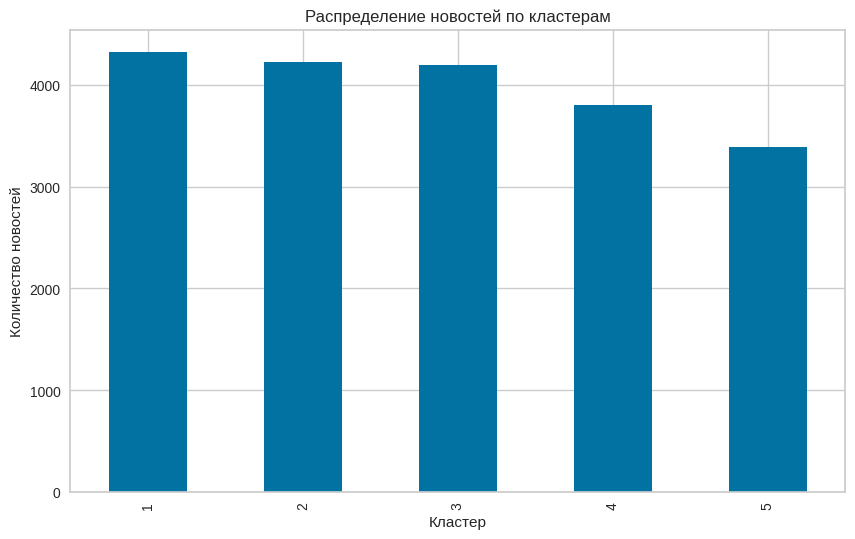

In [ ]:
plt.figure(figsize=(10, 6))
vk_news["cluster_w2v_kmeans"].value_counts().plot(kind="bar")
plt.title("Распределение новостей по кластерам")
plt.xlabel("Кластер")
plt.ylabel("Количество новостей")
plt.show()

In [ ]:
def get_top_keywords_w2v(model, clusters, labels, n_terms):
    centroids = model.cluster_centers_
    for i, centroid in enumerate(centroids):
        print(f'\nCluster {i + 1}')
        # Находим ближайшие векторы к центроиду в уменьшенном пространстве
        distances = np.linalg.norm(X_w2v_reduced - centroid, axis=1)
        closest_points_indices = distances.argsort()[:n_terms]
        # Используем индексы для получения оригинальных текстов
        closest_texts = vk_news.iloc[closest_points_indices]['preproced_title']
        all_words = ' '.join(closest_texts).split()
        unique_words = list(set(all_words))
        word_scores = {word: all_words.count(word) for word in unique_words}
        sorted_words = sorted(word_scores.items(), key=lambda item: item[1], reverse=True)[:n_terms]
        print(', '.join([word for word, _ in sorted_words]))

In [ ]:
get_top_keywords_w2v(kmeans_w, X_w2v_reduced, vk_news['cluster_w2v_kmeans'], 15)


Cluster 1
россии, '', сми, всу, любви, матче, борьбе, пишут, поможет, чм, сборная, мма, командой, терроризмом, рассказали

Cluster 2
telegram, суд, блокировке, отклонил, способна, иск, фсб, '', объяснил, россия, начали, банды, жалобу, завершении, наблюдателей

Cluster 3
истории, заявил, порошенко, '', города, танкер, погодин, калифорнии, сирии, рассказали, ран, причастность, тысячелетней, самолетом, трамп

Cluster 4
россию, '', сети, число, почему, человек, депутат, 35, из-за, моста, заголовком, кемерово, организации, жители, санкций

Cluster 5
'', движение, мосту, крымскому, 75, мире, «, уязвимости, предъявили, октября, объединении, запущено, ni, американских, сети


In [ ]:
categories = {1: 'В мире', 2: "Общество", 3: "Внешняя политика", 4: "Происшествия", 5: "Крымский мост"}

In [ ]:
vk_news['new_category_kmeans_w2v'] = vk_news['cluster_w2v_kmeans'].map(categories)
vk_news.head()

,id,href,title,text,likes,comments,date,time,preproced_title,vector_w2v,...,PCA_W2V5,vector_ft,vector_tfidf,PCA_TFIDF1,PCA_TFIDF2,PCA_TFIDF3,PCA_TFIDF4,PCA_TFIDF5,cluster_w2v_kmeans,new_category_kmeans_w2v
0,24006362,/20190201/1550280358.html,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28,2019-02-01,23:13:17,днр заявили задержании диверсантов причастных ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,-0.003941,"[-7.606929e-05, -0.00058498426, 0.00068065675,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.010099,-0.011744,0.003842,-0.006473,-0.000864,2,Общество
1,24006240,/20190201/1550268781.html,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",NaN,32,42,2019-02-01,22:38:41,житель урала заминировал '' тц из-за снятия со...,"[-0.026784008, 0.04596131, 0.026244625, 0.0303...",...,-0.004579,"[-0.007870973, 0.0034842503, 0.006534023, 0.00...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.014393,-0.025595,0.041813,-0.037069,0.252656,1,В мире
2,24006100,/20190201/1550282212.html,"В Черном море нашли ""потерянный флот Гитлера""",NaN,84,23,2019-02-01,21:58:52,черном море нашли потерянный флот гитлера '',"[-0.07443841, 0.11055287, 0.053822767, 0.08105...",...,-0.000396,"[-0.00947853, 0.004661638, 0.0063480376, 0.003...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.022243,-0.021548,-0.015491,0.001912,-0.004508,3,Внешняя политика
3,24005972,/20190202/1550283179.html,В США освободили задержанную российскую актрис...,NaN,58,35,2019-02-01,21:27:06,сша освободили задержанную российскую актрису ...,"[-0.0024304874, 0.0027163012, -0.0029920712, 0...",...,-0.000646,"[0.002087225, -0.00069175486, 0.0013854535, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.032802,0.009200,0.116478,-0.049111,-0.038658,2,Общество
4,24005764,/20190201/1550262848.html,Толкнувший Скабееву депутат Рады заявил о гроз...,NaN,45,145,2019-02-01,20:55:54,толкнувший скабееву депутат рады заявил грозящ...,"[-0.005795799, -0.0008357464, -0.011000597, 0....",...,0.000229,"[-0.00015284933, -0.00050091237, 7.749127e-05,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.006645,-0.014026,0.008126,-0.035236,-0.020674,2,Общество


In [ ]:
silhouette_w2v_kmeans = silhouette_score(vectors, kmeans_w.labels_)
db_index_w2v_kmeans = davies_bouldin_score(vectors, kmeans_w.labels_)
ch_index_w2v_kmeans = calinski_harabasz_score(vectors, kmeans_w.labels_)

In [ ]:
print(silhouette_w2v_kmeans)
print(db_index_w2v_kmeans)
print(ch_index_w2v_kmeans)

0.7140217896102425
0.4019715504379236
202099.3822831387


Значение silhouette_score указывает на то, что кластеры хорошо разделены и компактны. Чем ниже значение davies bouldin score, тем лучше качество кластеризации. Значение 0.4019 также указывает на достаточно хорошее качество кластеризации. Индекс Калински-Харабаша оценивает отношение суммы дисперсий между кластерами к сумме дисперсий внутри кластеров. Чем выше значение, тем лучше качество кластеризации. Значение 202099.3822831387 является очень высоким, что указывает на высокую степень разделенности кластеров и хорошую плотность внутри кластеров.

### Clustering with FastText Vectors:

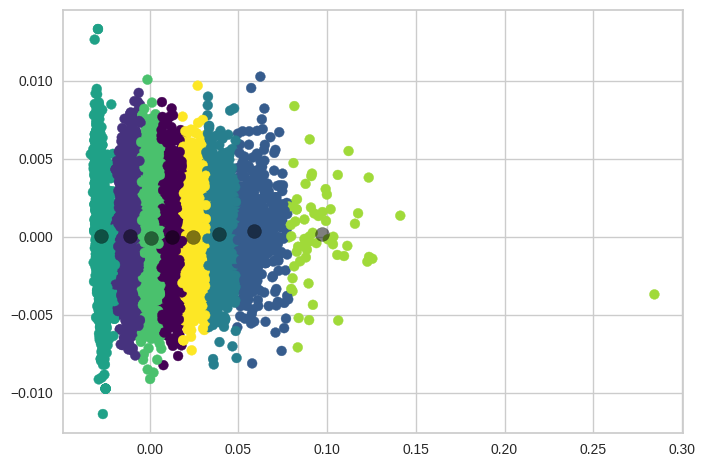

In [ ]:
vectors_ft = vk_news[['PCA_FT1', 'PCA_FT2', 'PCA_FT3', 'PCA_FT4', 'PCA_FT5']].to_numpy()

kmeans = KMeans(random_state=42)

y_kmeans = kmeans.fit_predict(vectors_ft)

plt.scatter(vectors_ft[:, 0], vectors_ft[:, 1], s=50, c=y_kmeans, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='black', alpha=0.5)
plt.show()

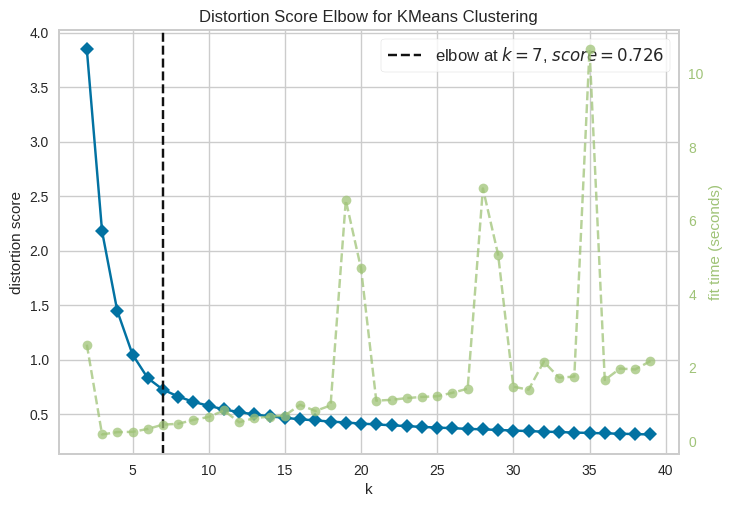

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
vis = KElbowVisualizer(kmeans, k=(2,40))
vis.fit(X_ft_reduced)
vis.show()

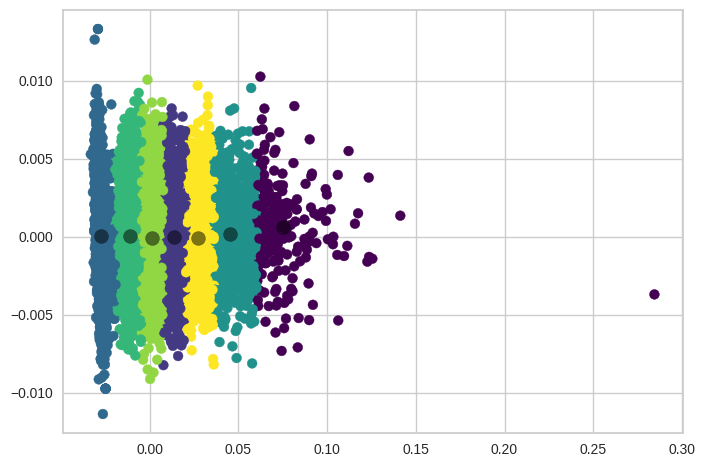

In [ ]:
vectors_ft = vk_news[['PCA_FT1', 'PCA_FT2', 'PCA_FT3', 'PCA_FT4', 'PCA_FT5']].to_numpy()

kmeans_ft = KMeans(n_clusters=7, random_state=42)

y_kmeans = kmeans_ft.fit_predict(vectors_ft)

plt.scatter(vectors_ft[:, 0], vectors_ft[:, 1], s=50, c=y_kmeans, cmap='viridis')
centers = kmeans_ft.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='black', alpha=0.5)
plt.show()

In [ ]:
vk_news['cluster_ft_kmeans'] = kmeans_ft.labels_ + 1
vk_news.head(3)

,id,href,title,text,likes,comments,date,time,preproced_title,vector_w2v,...,PCA_TFIDF4,PCA_TFIDF5,cluster_w2v_kmeans,new_category_kmeans_w2v,PCA_FT1,PCA_FT2,PCA_FT3,PCA_FT4,PCA_FT5,cluster_ft_kmeans
0,24006362,/20190201/1550280358.html,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28,2019-02-01,23:13:17,днр заявили задержании диверсантов причастных ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,-0.006473,-0.000864,2,Общество,-0.027765,0.002729,-0.000865,-0.000741,0.000913,3
1,24006240,/20190201/1550268781.html,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",NaN,32,42,2019-02-01,22:38:41,житель урала заминировал '' тц из-за снятия со...,"[-0.026784008, 0.04596131, 0.026244625, 0.0303...",...,-0.037069,0.252656,1,В мире,0.007368,0.000297,-0.000468,-0.001036,0.000167,6
2,24006100,/20190201/1550282212.html,"В Черном море нашли ""потерянный флот Гитлера""",NaN,84,23,2019-02-01,21:58:52,черном море нашли потерянный флот гитлера '',"[-0.07443841, 0.11055287, 0.053822767, 0.08105...",...,0.001912,-0.004508,3,Внешняя политика,0.016133,-0.003602,0.000833,-0.004214,-0.002570,2


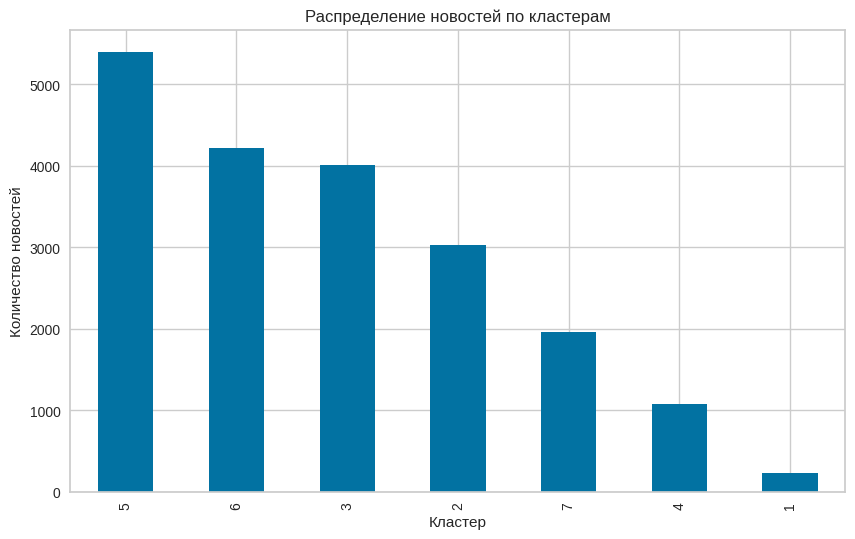

In [ ]:
plt.figure(figsize=(10, 6))
vk_news["cluster_ft_kmeans"].value_counts().plot(kind="bar")
plt.title("Распределение новостей по кластерам")
plt.xlabel("Кластер")
plt.ylabel("Количество новостей")
plt.show()

In [ ]:
get_top_keywords_w2v(kmeans_ft, X_ft_reduced, vk_news['cluster_ft_kmeans'], 15)


Cluster 1
почему, объяснили, объяснил, 50, '', сми, завоевала, путиным, запад, участница, bild, объявили, британских, американские, марафона

Cluster 2
почему, объяснил, объяснили, сми, сирии, минобороны, '', россии, контрольном, предъявили, гимна, номера, поместил, армии, страсбурге

Cluster 3
рублей, тысячи, сми, 8, великой, 5+, цены, 500, мост, 175, кемерово, россией, узнал, года, любим

Cluster 4
ми-8, крушения, красноярском, рублей, миллионов, '', крае, российских, 8, жены, ip-адресов, продажу, депутата, разблокировал, ni

Cluster 5
рублей, сми, москве, мосту, крымскому, '', nation, бомбу, водитель, автобуса, обнаружили, стрельбу, рассказали, саратовские, сети

Cluster 6
youtube, сми, американские, пишут, поможет, офисе, '', всу, ленинграде, стрельбу, рассказали, памятью, проблем, зеленые, российском

Cluster 7
'', предъявили, обвинение, объяснили, россии, доставит, которые, картины, сирии, попытка, объявили, выговор, призвал, личность, сша


In [ ]:
categories_ = {1: 'Общество', 2: "Внешняя политика", 3: "Торговля и экономика", 4: "Авиационные происшествия", 5: "Происшествия", 6: "В мире", 7: "Импорт и экспорт"}

In [ ]:
vk_news['new_category_kmeans_ft'] = vk_news['cluster_ft_kmeans'].map(categories_)
vk_news.head()

,id,href,title,text,likes,comments,date,time,preproced_title,vector_w2v,...,PCA_TFIDF5,cluster_w2v_kmeans,new_category_kmeans_w2v,PCA_FT1,PCA_FT2,PCA_FT3,PCA_FT4,PCA_FT5,cluster_ft_kmeans,new_category_kmeans_ft
0,24006362,/20190201/1550280358.html,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28,2019-02-01,23:13:17,днр заявили задержании диверсантов причастных ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,-0.000864,2,Общество,-0.027765,0.002729,-0.000865,-0.000741,0.000913,3,Торговля и экономика
1,24006240,/20190201/1550268781.html,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",NaN,32,42,2019-02-01,22:38:41,житель урала заминировал '' тц из-за снятия со...,"[-0.026784008, 0.04596131, 0.026244625, 0.0303...",...,0.252656,1,В мире,0.007368,0.000297,-0.000468,-0.001036,0.000167,6,В мире
2,24006100,/20190201/1550282212.html,"В Черном море нашли ""потерянный флот Гитлера""",NaN,84,23,2019-02-01,21:58:52,черном море нашли потерянный флот гитлера '',"[-0.07443841, 0.11055287, 0.053822767, 0.08105...",...,-0.004508,3,Внешняя политика,0.016133,-0.003602,0.000833,-0.004214,-0.002570,2,Внешняя политика
3,24005972,/20190202/1550283179.html,В США освободили задержанную российскую актрис...,NaN,58,35,2019-02-01,21:27:06,сша освободили задержанную российскую актрису ...,"[-0.0024304874, 0.0027163012, -0.0029920712, 0...",...,-0.038658,2,Общество,-0.027239,0.002362,-0.000617,0.004634,0.000716,3,Торговля и экономика
4,24005764,/20190201/1550262848.html,Толкнувший Скабееву депутат Рады заявил о гроз...,NaN,45,145,2019-02-01,20:55:54,толкнувший скабееву депутат рады заявил грозящ...,"[-0.005795799, -0.0008357464, -0.011000597, 0....",...,-0.020674,2,Общество,-0.028042,-0.000530,0.000407,-0.001116,0.002648,3,Торговля и экономика


In [ ]:
silhouette_ft_kmeans = silhouette_score(vectors_ft, kmeans_ft.labels_)
db_index_ft_kmeans = davies_bouldin_score(vectors_ft, kmeans_ft.labels_)
ch_index_ft_kmeans = calinski_harabasz_score(vectors_ft, kmeans_ft.labels_)

In [ ]:
print(silhouette_ft_kmeans)
print(db_index_ft_kmeans)
print(ch_index_ft_kmeans)

0.4295509
0.7739720020853111
42217.72620476115


Значение 0.439 является средним, что указывает на среднее качество кластеризации. Это значение показывает, что кластеры имеют некоторое пересечение, и объекты внутри кластеров не так хорошо разделены, как могли бы быть. Значение 0.7739 указывает на умеренное качество кластеризации. Это значение свидетельствует о том, что кластеры не так хорошо разделены и имеют определенное сходство между собой. Индекс Калински-Харабаша оценивает отношение суммы дисперсий между кластерами к сумме дисперсий внутри кластеров. Чем выше значение, тем лучше качество кластеризации. Значение 42217 указывает на хорошее качество кластеризации. Это значение ниже по сравнению с предыдущим значением для кластеризации на основе word2vec, что говорит о том, что разделение между кластерами не так выражено.

### Clustering with TF-IDF:

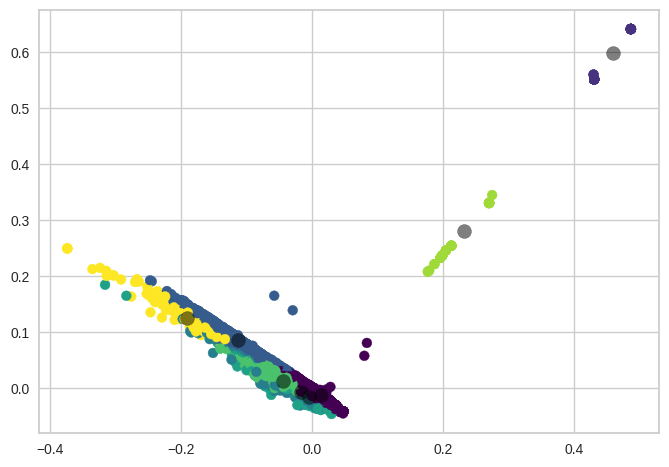

In [ ]:
vectors_idf = vk_news[['PCA_TFIDF1', 'PCA_TFIDF2', 'PCA_TFIDF3', 'PCA_TFIDF4', 'PCA_TFIDF5']].to_numpy()

kmeans_idf = KMeans(random_state=42)

y_kmeans = kmeans_idf.fit_predict(vectors_idf)

plt.scatter(vectors_idf[:, 0], vectors_idf[:, 1], s=50, c=y_kmeans, cmap='viridis')
centers = kmeans_idf.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='black', alpha=0.5)
plt.show()

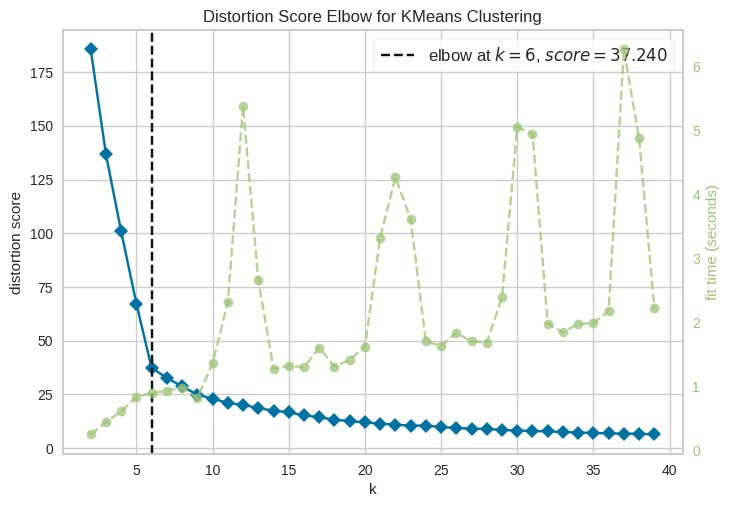

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
vis = KElbowVisualizer(kmeans, k=(2,40))
vis.fit(X_tfidf_reduced)
vis.show()

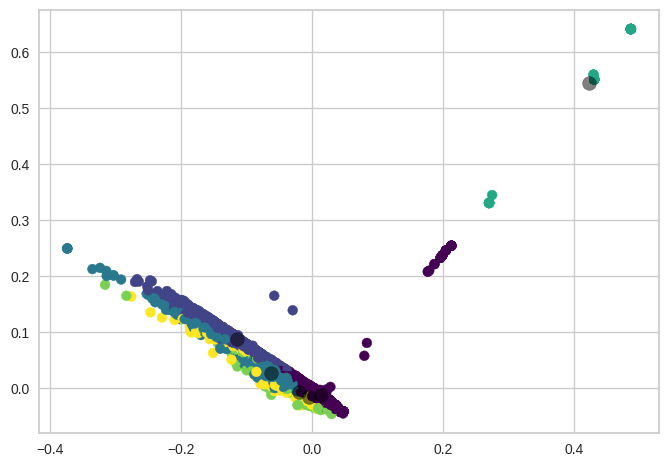

In [ ]:
vectors_idf = vk_news[['PCA_TFIDF1', 'PCA_TFIDF2', 'PCA_TFIDF3', 'PCA_TFIDF4', 'PCA_TFIDF5']].to_numpy()

kmeans_tfidf = KMeans(n_clusters=6, random_state=42)

y_kmeans = kmeans_tfidf.fit_predict(vectors_idf)

plt.scatter(vectors_idf[:, 0], vectors_idf[:, 1], s=50, c=y_kmeans, cmap='viridis')
centers = kmeans_tfidf.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='black', alpha=0.5)
plt.show()

In [ ]:
vk_news['cluster_tfidf_kmeans'] = kmeans_tfidf.labels_ + 1
vk_news.head(3)

,id,href,title,text,likes,comments,date,time,preproced_title,vector_w2v,...,cluster_w2v_kmeans,new_category_kmeans_w2v,PCA_FT1,PCA_FT2,PCA_FT3,PCA_FT4,PCA_FT5,cluster_ft_kmeans,new_category_kmeans_ft,cluster_tfidf_kmeans
0,24006362,/20190201/1550280358.html,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28,2019-02-01,23:13:17,днр заявили задержании диверсантов причастных ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,2,Общество,-0.027765,0.002729,-0.000865,-0.000741,0.000913,3,Торговля и экономика,1
1,24006240,/20190201/1550268781.html,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",NaN,32,42,2019-02-01,22:38:41,житель урала заминировал '' тц из-за снятия со...,"[-0.026784008, 0.04596131, 0.026244625, 0.0303...",...,1,В мире,0.007368,0.000297,-0.000468,-0.001036,0.000167,6,В мире,5
2,24006100,/20190201/1550282212.html,"В Черном море нашли ""потерянный флот Гитлера""",NaN,84,23,2019-02-01,21:58:52,черном море нашли потерянный флот гитлера '',"[-0.07443841, 0.11055287, 0.053822767, 0.08105...",...,3,Внешняя политика,0.016133,-0.003602,0.000833,-0.004214,-0.002570,2,Внешняя политика,1


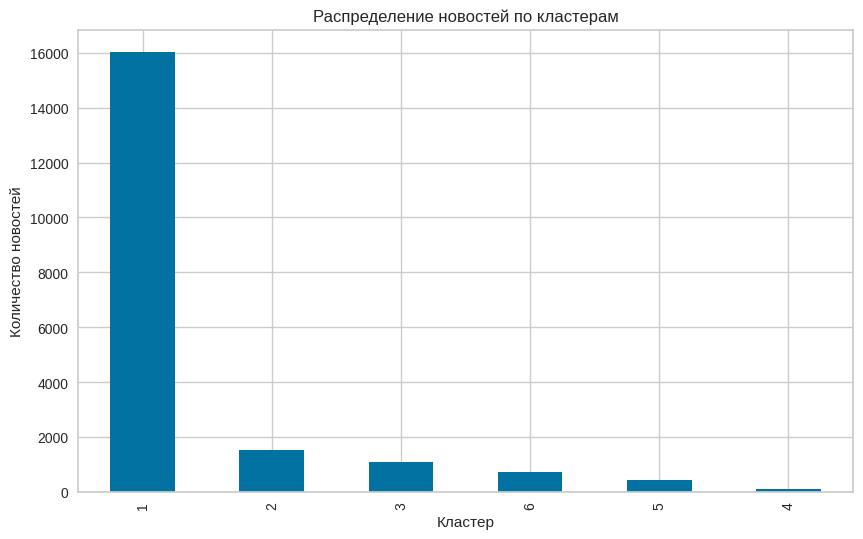

In [ ]:
plt.figure(figsize=(10, 6))
vk_news["cluster_tfidf_kmeans"].value_counts().plot(kind="bar")
plt.title("Распределение новостей по кластерам")
plt.xlabel("Кластер")
plt.ylabel("Количество новостей")
plt.show()

In [ ]:
get_top_keywords_w2v(kmeans_tfidf, X_tfidf_reduced, vk_news['cluster_tfidf_kmeans'], 15)


Cluster 1
чемпиона, трамп, титул, нурмагомедов, ufc, '', объяснил, хабиб, сми, россии, контрольном, предъявили, номера, сирии, поместил

Cluster 2
'', самую, киева, прислал, крымскую, неудачливую, каких, системы, рассказали, атаку, сети, поручил, правду, ответило, ярославских

Cluster 3
2018, '', года, году, —, гектар, навигатор, поехать, лето, пройдут, 9, 92, туристы, пост, начнут

Cluster 4
—, '', 2, северного, потока, северный, сша, поток, строительство, против, швеции, выйти, откажется, европы, рада

Cluster 5
латвии, рейс, восхождение, электрички, задержали, рассказали, воспитывать, россией, якутска, дуэльного, отец, пейдж, санкций, жителей, мозги

Cluster 6
'', северного, 2, против, —, потока-2, потока, 22, северный, призвала, сша, поток, человек, санкции, 12


In [ ]:
categories_idf = {1: 'Спорт', 2: "Украинский конфликт", 3: "Общество", 4: "Внешняя политика", 5: "Происшествия", 6: "Северный поток"}

In [ ]:
vk_news['new_category_kmeans_idf'] = vk_news['cluster_tfidf_kmeans'].map(categories_idf)
vk_news.head()

,id,href,title,text,likes,comments,date,time,preproced_title,vector_w2v,...,new_category_kmeans_w2v,PCA_FT1,PCA_FT2,PCA_FT3,PCA_FT4,PCA_FT5,cluster_ft_kmeans,new_category_kmeans_ft,cluster_tfidf_kmeans,new_category_kmeans_idf
0,24006362,/20190201/1550280358.html,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28,2019-02-01,23:13:17,днр заявили задержании диверсантов причастных ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,Общество,-0.027765,0.002729,-0.000865,-0.000741,0.000913,3,Торговля и экономика,1,Спорт
1,24006240,/20190201/1550268781.html,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",NaN,32,42,2019-02-01,22:38:41,житель урала заминировал '' тц из-за снятия со...,"[-0.026784008, 0.04596131, 0.026244625, 0.0303...",...,В мире,0.007368,0.000297,-0.000468,-0.001036,0.000167,6,В мире,5,Происшествия
2,24006100,/20190201/1550282212.html,"В Черном море нашли ""потерянный флот Гитлера""",NaN,84,23,2019-02-01,21:58:52,черном море нашли потерянный флот гитлера '',"[-0.07443841, 0.11055287, 0.053822767, 0.08105...",...,Внешняя политика,0.016133,-0.003602,0.000833,-0.004214,-0.002570,2,Внешняя политика,1,Спорт
3,24005972,/20190202/1550283179.html,В США освободили задержанную российскую актрис...,NaN,58,35,2019-02-01,21:27:06,сша освободили задержанную российскую актрису ...,"[-0.0024304874, 0.0027163012, -0.0029920712, 0...",...,Общество,-0.027239,0.002362,-0.000617,0.004634,0.000716,3,Торговля и экономика,3,Общество
4,24005764,/20190201/1550262848.html,Толкнувший Скабееву депутат Рады заявил о гроз...,NaN,45,145,2019-02-01,20:55:54,толкнувший скабееву депутат рады заявил грозящ...,"[-0.005795799, -0.0008357464, -0.011000597, 0....",...,Общество,-0.028042,-0.000530,0.000407,-0.001116,0.002648,3,Торговля и экономика,1,Спорт


In [ ]:
silhouette_idf_kmeans = silhouette_score(vectors_idf, kmeans_tfidf.labels_)
db_index_idf_kmeans = davies_bouldin_score(vectors_idf, kmeans_tfidf.labels_)
ch_index_idf_kmeans = calinski_harabasz_score(vectors_idf, kmeans_tfidf.labels_)

In [ ]:
print(silhouette_idf_kmeans)
print(db_index_idf_kmeans)
print(ch_index_idf_kmeans)

0.7794122383385766
0.4192173055986299
21124.600758810106


Значение silhouette score равное 0.7794 является достаточно высоким, что указывает на хорошее качество кластеризации. Значение davies bouldin score , которое равно 0.4192, указывает также на хорошее качество кластеризации. Это свидетельствует о том, что кластеры достаточно разделены и имеют низкое сходство между собой. Значение Calinski-Harabasz Score указывает на умеренную разделенность кластеров, хотя и не столь высокую, как в случае с word2vec.

# Agglomerative hierarchical clustering

### Clustering with Word2Vec Vectors:

In [ ]:
vectors = vk_news[['PCA_W2V1', 'PCA_W2V2', 'PCA_W2V3', 'PCA_W2V4', 'PCA_W2V5']].to_numpy()

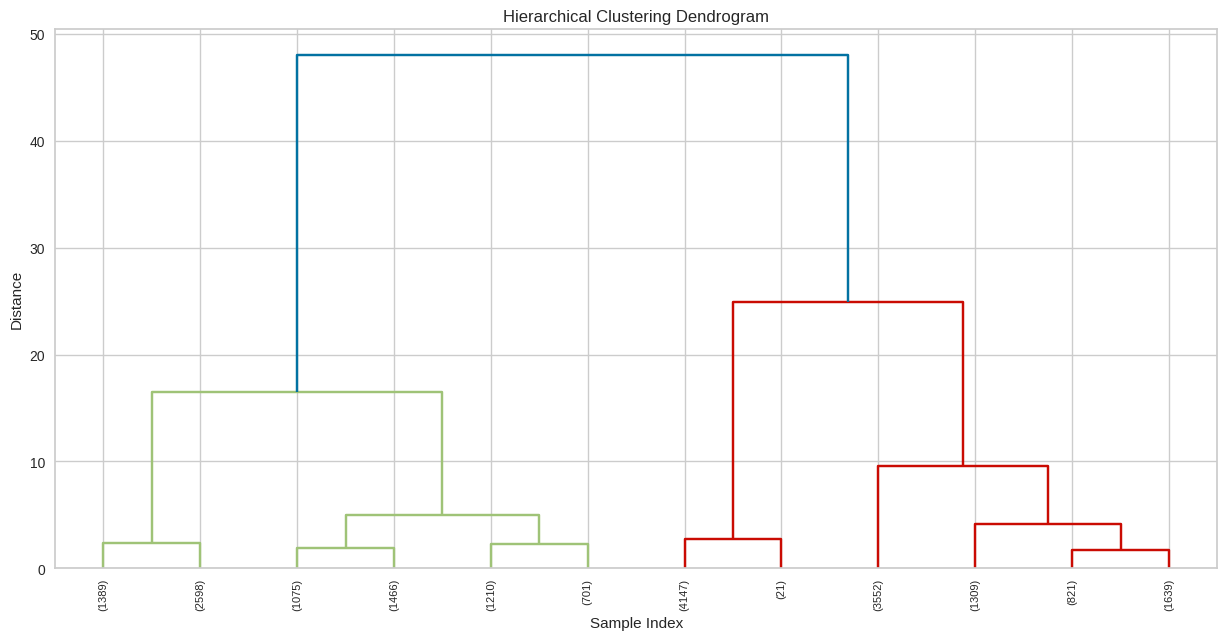

In [ ]:
plt.figure(figsize =(15, 7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
dendrogram(linkage(vectors, method ='ward'), leaf_rotation=90., leaf_font_size=8., truncate_mode='lastp', p=12)
plt.show()

По данной дендрограмме можно определить, что оптимальное количество кластеров должно равняться 4.

Давайте посмотрим на silhouette score:

In [ ]:
range_n_clusters = range(2, 30)

In [ ]:
best_n_clusters = 0
best_silhouette_avg = -1
silhouette_avgs = []

for n_clusters in range_n_clusters:
    agg_cluster = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels_agg = agg_cluster.fit_predict(vectors)
    silhouette_avg = silhouette_score(vectors, cluster_labels_agg)
    silhouette_avgs.append(silhouette_avg)
    if silhouette_avg > best_silhouette_avg:
        best_silhouette_avg = silhouette_avg
        best_n_clusters = n_clusters

print("Оптимальное количество кластеров:", best_n_clusters)
print("Лучший Silhouette score:", best_silhouette_avg)

Оптимальное количество кластеров: 8
Лучший Silhouette score: 0.6944372144252426


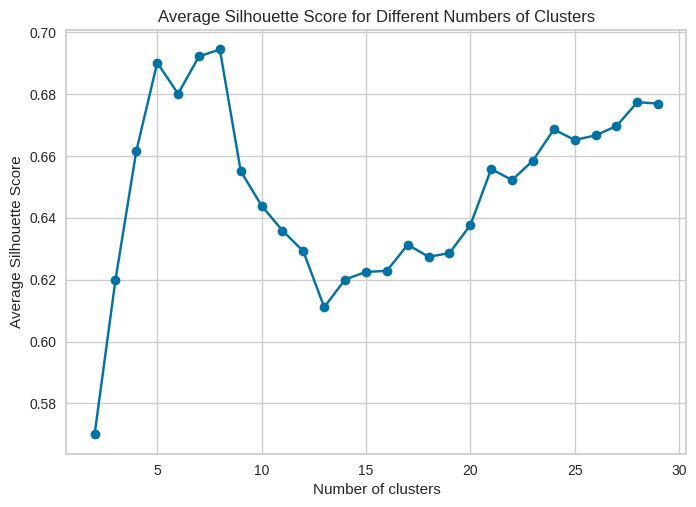

In [ ]:
plt.plot(range_n_clusters, silhouette_avgs, marker='o')
plt.title("Average Silhouette Score for Different Numbers of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Average Silhouette Score")
plt.show()

In [ ]:
agg_cluster = AgglomerativeClustering(n_clusters=8)
cluster_labels_agg = agg_cluster.fit_predict(vectors)
vk_news['cluster_w2v_agg'] = agg_cluster.labels_ + 1
vk_news.head()

,id,href,title,text,likes,comments,date,time,preproced_title,vector_w2v,...,PCA_FT1,PCA_FT2,PCA_FT3,PCA_FT4,PCA_FT5,cluster_ft_kmeans,new_category_kmeans_ft,cluster_tfidf_kmeans,new_category_kmeans_idf,cluster_w2v_agg
0,24006362,/20190201/1550280358.html,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28,2019-02-01,23:13:17,днр заявили задержании диверсантов причастных ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,-0.027765,0.002729,-0.000865,-0.000741,0.000913,3,Торговля и экономика,1,Спорт,1
1,24006240,/20190201/1550268781.html,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",NaN,32,42,2019-02-01,22:38:41,житель урала заминировал '' тц из-за снятия со...,"[-0.026784008, 0.04596131, 0.026244625, 0.0303...",...,0.007368,0.000297,-0.000468,-0.001036,0.000167,6,В мире,5,Происшествия,3
2,24006100,/20190201/1550282212.html,"В Черном море нашли ""потерянный флот Гитлера""",NaN,84,23,2019-02-01,21:58:52,черном море нашли потерянный флот гитлера '',"[-0.07443841, 0.11055287, 0.053822767, 0.08105...",...,0.016133,-0.003602,0.000833,-0.004214,-0.002570,2,Внешняя политика,1,Спорт,8
3,24005972,/20190202/1550283179.html,В США освободили задержанную российскую актрис...,NaN,58,35,2019-02-01,21:27:06,сша освободили задержанную российскую актрису ...,"[-0.0024304874, 0.0027163012, -0.0029920712, 0...",...,-0.027239,0.002362,-0.000617,0.004634,0.000716,3,Торговля и экономика,3,Общество,1
4,24005764,/20190201/1550262848.html,Толкнувший Скабееву депутат Рады заявил о гроз...,NaN,45,145,2019-02-01,20:55:54,толкнувший скабееву депутат рады заявил грозящ...,"[-0.005795799, -0.0008357464, -0.011000597, 0....",...,-0.028042,-0.000530,0.000407,-0.001116,0.002648,3,Торговля и экономика,1,Спорт,1


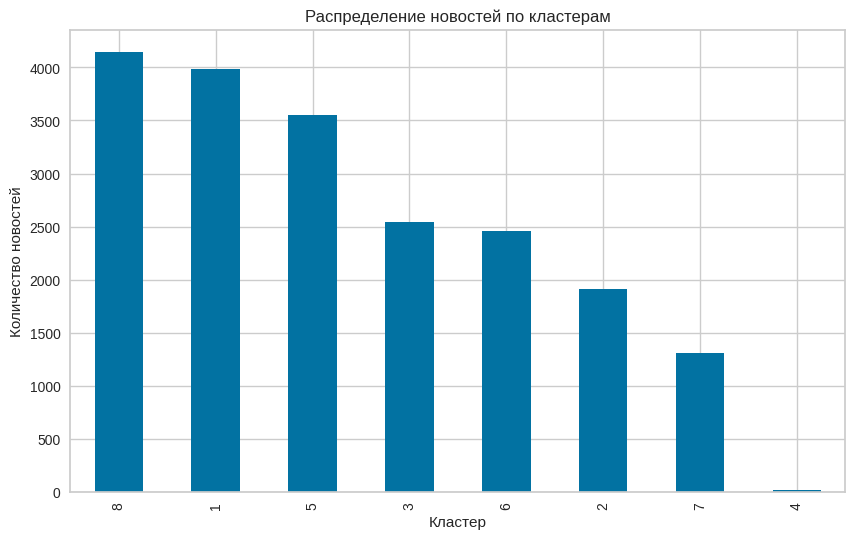

In [ ]:
plt.figure(figsize=(10, 6))
vk_news["cluster_w2v_agg"].value_counts().plot(kind="bar")
plt.title("Распределение новостей по кластерам")
plt.xlabel("Кластер")
plt.ylabel("Количество новостей")
plt.show()

In [ ]:
def get_top_keywords_agg(vectors, clusters, labels, n_terms, original_data):
    unique_clusters = np.unique(clusters)
    pca = PCA(n_components=2)
    vectors_reduced = pca.fit_transform(vectors)

    for cluster in unique_clusters:
        print(f'\nCluster {cluster + 1}')
        cluster_indices = np.where(clusters == cluster)
        cluster_vectors = vectors_reduced[cluster_indices]
        centroid = np.mean(cluster_vectors, axis=0)
        distances = np.linalg.norm(cluster_vectors - centroid, axis=1)
        closest_points_indices = cluster_indices[0][distances.argsort()[:n_terms]]
        closest_texts = original_data.iloc[closest_points_indices]['preproced_title']
        all_words = ' '.join(closest_texts).split()
        unique_words = list(set(all_words))
        word_scores = {word: all_words.count(word) for word in unique_words}
        sorted_words = sorted(word_scores.items(), key=lambda item: item[1], reverse=True)[:n_terms]

        print(', '.join([word for word, _ in sorted_words]))

In [ ]:
get_top_keywords_agg(vectors, cluster_labels_agg, labels=None, n_terms=15, original_data=vk_news)


Cluster 1
'', начали, киева, краснодаре, президента, роухани, сирии, антиядерного, около, эксперты, ядерное, электричество, предотвратил, сша, детство

Cluster 2
'', facebook, россии, 500, instagram, рублей, химический, лото, дзюба, испытаниях, вывезти, китай, медвежьих, оштрафовал, google

Cluster 3
google, москве, maps, '', объяснил, цены, монстров, предъявили, валерий, рыбака, автобуса, съели, мост, военно-морского, керчи

Cluster 4
—, '', путешествиях, путин, саммита, реальный, дорогах, госпитализировали, сети, двигатель, владимира, фото, иностранцы, войне, птица

Cluster 5
'', россии, сми, любви, германии, поможет, всу, читатели, мма, обороны, рассказали, памятью, британских, главную, марсианина

Cluster 6
twitter, '', минобороны, сми, россии, модернизированный, которые, американском, читатели, первый, ми-8, обнаружили, номера, ni, норвегии

Cluster 7
'', «, 15, умер, —, почему, миллионов, », сесть, камаза, крымском, bmw, tokens, 13, bild

Cluster 8
'', россии, рассказали, сша, м

In [ ]:
categories_agg = {1: "Внешняя политика", 2: "Социальные сети", 3: "Экономика", 4: "Общество", 5: "В мире", 6: "Общество", 7: "Происшествия", 8: "Политика"}

In [ ]:
vk_news['new_category_agg_w2v'] = vk_news['cluster_w2v_agg'].map(categories_agg)
vk_news.head()

,id,href,title,text,likes,comments,date,time,preproced_title,vector_w2v,...,PCA_FT2,PCA_FT3,PCA_FT4,PCA_FT5,cluster_ft_kmeans,new_category_kmeans_ft,cluster_tfidf_kmeans,new_category_kmeans_idf,cluster_w2v_agg,new_category_agg_w2v
0,24006362,/20190201/1550280358.html,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28,2019-02-01,23:13:17,днр заявили задержании диверсантов причастных ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,0.002729,-0.000865,-0.000741,0.000913,3,Торговля и экономика,1,Спорт,1,Внешняя политика
1,24006240,/20190201/1550268781.html,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",NaN,32,42,2019-02-01,22:38:41,житель урала заминировал '' тц из-за снятия со...,"[-0.026784008, 0.04596131, 0.026244625, 0.0303...",...,0.000297,-0.000468,-0.001036,0.000167,6,В мире,5,Происшествия,3,Экономика
2,24006100,/20190201/1550282212.html,"В Черном море нашли ""потерянный флот Гитлера""",NaN,84,23,2019-02-01,21:58:52,черном море нашли потерянный флот гитлера '',"[-0.07443841, 0.11055287, 0.053822767, 0.08105...",...,-0.003602,0.000833,-0.004214,-0.002570,2,Внешняя политика,1,Спорт,8,Политика
3,24005972,/20190202/1550283179.html,В США освободили задержанную российскую актрис...,NaN,58,35,2019-02-01,21:27:06,сша освободили задержанную российскую актрису ...,"[-0.0024304874, 0.0027163012, -0.0029920712, 0...",...,0.002362,-0.000617,0.004634,0.000716,3,Торговля и экономика,3,Общество,1,Внешняя политика
4,24005764,/20190201/1550262848.html,Толкнувший Скабееву депутат Рады заявил о гроз...,NaN,45,145,2019-02-01,20:55:54,толкнувший скабееву депутат рады заявил грозящ...,"[-0.005795799, -0.0008357464, -0.011000597, 0....",...,-0.000530,0.000407,-0.001116,0.002648,3,Торговля и экономика,1,Спорт,1,Внешняя политика


In [ ]:
silhouette_idf_agg = silhouette_score(vectors, agg_cluster.labels_)
db_index_idf_agg = davies_bouldin_score(vectors, agg_cluster.labels_)
ch_index_idf_agg = calinski_harabasz_score(vectors, agg_cluster.labels_)

In [ ]:
print(silhouette_idf_agg)
print(db_index_idf_agg)
print(ch_index_idf_agg)

0.6944372144252426
0.533860191434268
222645.01258302652


Значение silhouette score 0.694 является высоким, что указывает на хорошее качество кластеризации. Значение Davies Bouldin score свидетельствует о том, что кластеры достаточно хорошо разделены и имеют низкое сходство между собой.Индекс Калински-Харабаша оценивает отношение суммы дисперсий между кластерами к сумме дисперсий внутри кластеров. Чем выше значение, тем лучше качество кластеризации. Значение 222645.012 указывает на высокое качество кластеризации. Это значение показывает, что кластеры хорошо разделены и плотны внутри.

### Clustering with FasText Vectors:

In [ ]:
vectors_ft = vk_news[['PCA_FT1', 'PCA_FT2', 'PCA_FT3', 'PCA_FT4', 'PCA_FT5']].to_numpy()

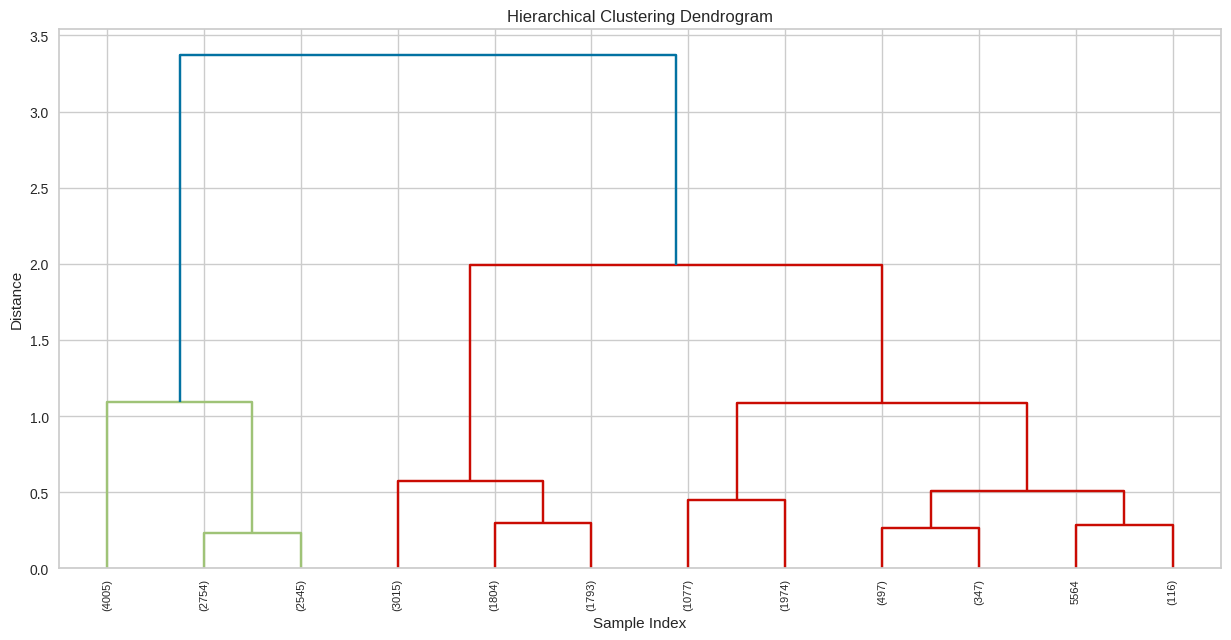

In [ ]:
plt.figure(figsize =(15, 7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
dendrogram(linkage(vectors_ft, method ='ward'), leaf_rotation=90., leaf_font_size=8., truncate_mode='lastp', p=12)
plt.show()

количество кластеров по дендрограмме - 3.

In [ ]:
range_n_clusters = range(2, 30)

best_n_clusters = 0
best_silhouette_avg = -1
silhouette_avgs = []

for n_clusters in range_n_clusters:
    agg_cluster = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels_agg = agg_cluster.fit_predict(vectors_ft)
    silhouette_avg = silhouette_score(vectors_ft, cluster_labels_agg)
    silhouette_avgs.append(silhouette_avg)
    if silhouette_avg > best_silhouette_avg:
        best_silhouette_avg = silhouette_avg
        best_n_clusters = n_clusters

print("Оптимальное количество кластеров:", best_n_clusters)
print("Лучший Silhouette score:", best_silhouette_avg)

Оптимальное количество кластеров: 2
Лучший Silhouette score: 0.48265392


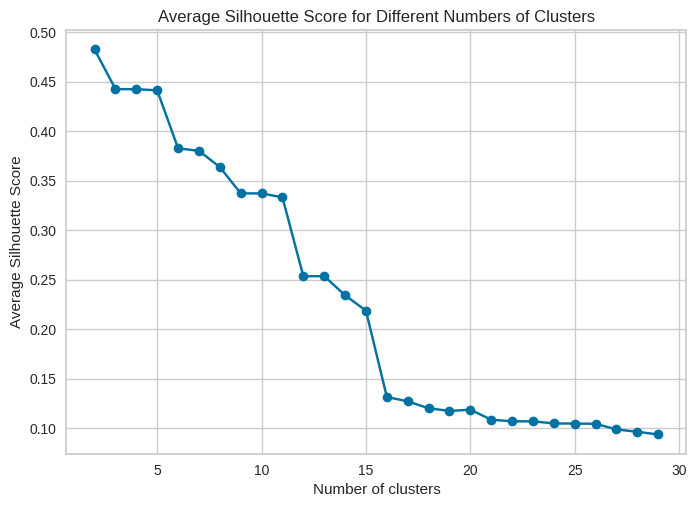

In [ ]:
plt.plot(range_n_clusters, silhouette_avgs, marker='o')
plt.title("Average Silhouette Score for Different Numbers of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Average Silhouette Score")
plt.show()

In [ ]:
agg_cluster_ft = AgglomerativeClustering(n_clusters=2)
cluster_labels_agg = agg_cluster_ft.fit_predict(vectors_ft)
vk_news['cluster_ft_agg'] = agg_cluster_ft.labels_ + 1
vk_news.head()

,id,href,title,text,likes,comments,date,time,preproced_title,vector_w2v,...,PCA_FT3,PCA_FT4,PCA_FT5,cluster_ft_kmeans,new_category_kmeans_ft,cluster_tfidf_kmeans,new_category_kmeans_idf,cluster_w2v_agg,new_category_agg_w2v,cluster_ft_agg
0,24006362,/20190201/1550280358.html,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28,2019-02-01,23:13:17,днр заявили задержании диверсантов причастных ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,-0.000865,-0.000741,0.000913,3,Торговля и экономика,1,Спорт,1,Внешняя политика,2
1,24006240,/20190201/1550268781.html,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",NaN,32,42,2019-02-01,22:38:41,житель урала заминировал '' тц из-за снятия со...,"[-0.026784008, 0.04596131, 0.026244625, 0.0303...",...,-0.000468,-0.001036,0.000167,6,В мире,5,Происшествия,3,Экономика,1
2,24006100,/20190201/1550282212.html,"В Черном море нашли ""потерянный флот Гитлера""",NaN,84,23,2019-02-01,21:58:52,черном море нашли потерянный флот гитлера '',"[-0.07443841, 0.11055287, 0.053822767, 0.08105...",...,0.000833,-0.004214,-0.002570,2,Внешняя политика,1,Спорт,8,Политика,1
3,24005972,/20190202/1550283179.html,В США освободили задержанную российскую актрис...,NaN,58,35,2019-02-01,21:27:06,сша освободили задержанную российскую актрису ...,"[-0.0024304874, 0.0027163012, -0.0029920712, 0...",...,-0.000617,0.004634,0.000716,3,Торговля и экономика,3,Общество,1,Внешняя политика,2
4,24005764,/20190201/1550262848.html,Толкнувший Скабееву депутат Рады заявил о гроз...,NaN,45,145,2019-02-01,20:55:54,толкнувший скабееву депутат рады заявил грозящ...,"[-0.005795799, -0.0008357464, -0.011000597, 0....",...,0.000407,-0.001116,0.002648,3,Торговля и экономика,1,Спорт,1,Внешняя политика,2


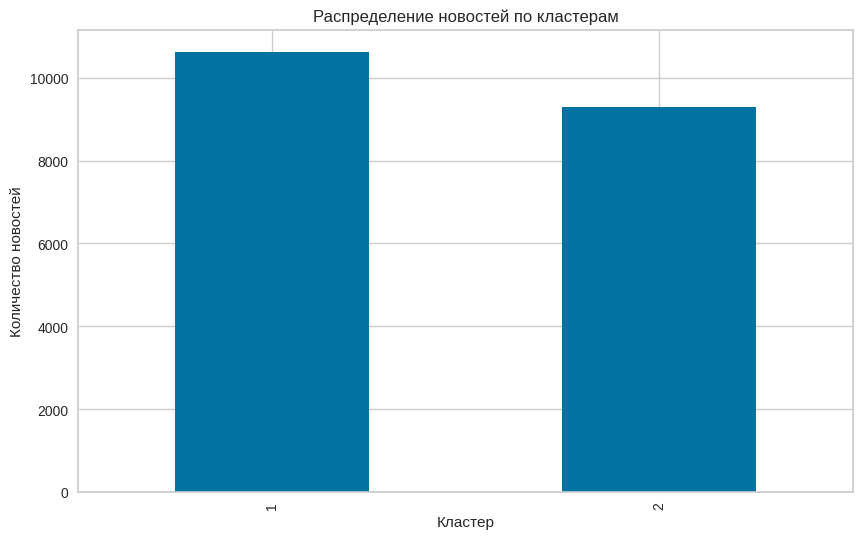

In [ ]:
plt.figure(figsize=(10, 6))
vk_news["cluster_ft_agg"].value_counts().plot(kind="bar")
plt.title("Распределение новостей по кластерам")
plt.xlabel("Кластер")
plt.ylabel("Количество новостей")
plt.show()

In [ ]:
get_top_keywords_agg(vectors_ft, cluster_labels_agg, labels=None, n_terms=15, original_data=vk_news)


Cluster 1
сми, узнали, '', почему, россии, служить, депутата, гимна, минск, выпустить, сети, ран, женщинам, главреда, выяснили

Cluster 2
сша, '', российский, 8, свое, 9, васильев, national, девятый, 23, реальные, 100, упавший, кольца, начнут


In [ ]:
categories_agg_ft = {1: "Происшествия", 2: "Политика"}

In [ ]:
vk_news['new_category_agg_ft'] = vk_news['cluster_ft_agg'].map(categories_agg_ft)
vk_news.head()

,id,href,title,text,likes,comments,date,time,preproced_title,vector_w2v,...,PCA_FT4,PCA_FT5,cluster_ft_kmeans,new_category_kmeans_ft,cluster_tfidf_kmeans,new_category_kmeans_idf,cluster_w2v_agg,new_category_agg_w2v,cluster_ft_agg,new_category_agg_ft
0,24006362,/20190201/1550280358.html,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28,2019-02-01,23:13:17,днр заявили задержании диверсантов причастных ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,-0.000741,0.000913,3,Торговля и экономика,1,Спорт,1,Внешняя политика,2,Политика
1,24006240,/20190201/1550268781.html,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",NaN,32,42,2019-02-01,22:38:41,житель урала заминировал '' тц из-за снятия со...,"[-0.026784008, 0.04596131, 0.026244625, 0.0303...",...,-0.001036,0.000167,6,В мире,5,Происшествия,3,Экономика,1,Происшествия
2,24006100,/20190201/1550282212.html,"В Черном море нашли ""потерянный флот Гитлера""",NaN,84,23,2019-02-01,21:58:52,черном море нашли потерянный флот гитлера '',"[-0.07443841, 0.11055287, 0.053822767, 0.08105...",...,-0.004214,-0.002570,2,Внешняя политика,1,Спорт,8,Политика,1,Происшествия
3,24005972,/20190202/1550283179.html,В США освободили задержанную российскую актрис...,NaN,58,35,2019-02-01,21:27:06,сша освободили задержанную российскую актрису ...,"[-0.0024304874, 0.0027163012, -0.0029920712, 0...",...,0.004634,0.000716,3,Торговля и экономика,3,Общество,1,Внешняя политика,2,Политика
4,24005764,/20190201/1550262848.html,Толкнувший Скабееву депутат Рады заявил о гроз...,NaN,45,145,2019-02-01,20:55:54,толкнувший скабееву депутат рады заявил грозящ...,"[-0.005795799, -0.0008357464, -0.011000597, 0....",...,-0.001116,0.002648,3,Торговля и экономика,1,Спорт,1,Внешняя политика,2,Политика


In [ ]:
silhouette_ft_agg = silhouette_score(vectors_ft, agg_cluster_ft.labels_)
db_index_ft_agg = davies_bouldin_score(vectors_ft, agg_cluster_ft.labels_)
ch_index_ft_agg = calinski_harabasz_score(vectors_ft, agg_cluster_ft.labels_)

In [ ]:
print(silhouette_ft_agg)
print(db_index_ft_agg)
print(ch_index_ft_agg)

0.48265392
0.6986823143152066
26428.749260359524


Значение Silhouette Score 0.483 является средним, что указывает на умеренное качество кластеризации. Значение Davies-Bouldin Index
 свидетельствует о том, что кластеры не так хорошо разделены и имеют определенное сходство между собой. Значение Calinski-Harabasz Score 26428.74 указывает на среднее качество кластеризации.

### Clustering with TF-IDF

In [ ]:
vectors_idf = vk_news[['PCA_TFIDF1', 'PCA_TFIDF2', 'PCA_TFIDF3', 'PCA_TFIDF4', 'PCA_TFIDF5']].to_numpy()

In [ ]:
plt.figure(figsize =(15, 7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
dendrogram(linkage(vectors_idf, method ='ward'), leaf_rotation=90., leaf_font_size=8., truncate_mode='lastp', p=12)
plt.show()

По дендрограмме кластеров должно быть 6.

In [ ]:
range_n_clusters = range(2, 30)

best_n_clusters = 0
best_silhouette_avg = -1
silhouette_avgs = []

for n_clusters in range_n_clusters:
    agg_cluster = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels_agg_idf = agg_cluster.fit_predict(vectors_idf)
    silhouette_avg = silhouette_score(vectors_idf, cluster_labels_agg_idf)
    silhouette_avgs.append(silhouette_avg)
    if silhouette_avg > best_silhouette_avg:
        best_silhouette_avg = silhouette_avg
        best_n_clusters = n_clusters

print("Оптимальное количество кластеров:", best_n_clusters)
print("Лучший Silhouette score:", best_silhouette_avg)

Оптимальное количество кластеров: 2
Лучший Silhouette score: 0.8541774551674124


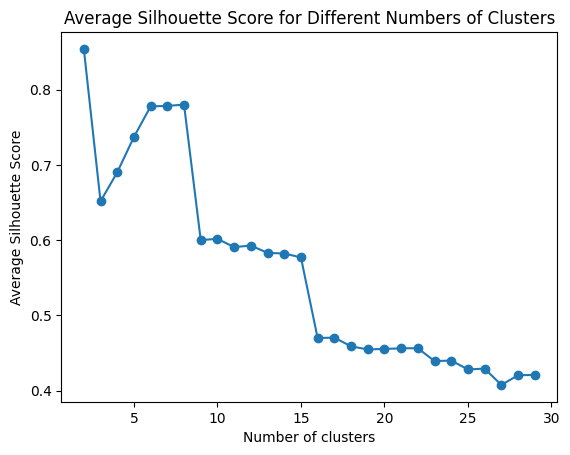

In [ ]:
plt.plot(range_n_clusters, silhouette_avgs, marker='o')
plt.title("Average Silhouette Score for Different Numbers of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Average Silhouette Score")
plt.show()

In [ ]:
agg_cluster_idf = AgglomerativeClustering(n_clusters=2)
cluster_labels_agg = agg_cluster_idf.fit_predict(vectors_idf)
vk_news['cluster_idf_agg'] = agg_cluster_idf.labels_ + 1
vk_news.head()

,id,href,title,text,likes,comments,date,time,preproced_title,preproced_text,vector_tfidf,PCA_TFIDF1,PCA_TFIDF2,PCA_TFIDF3,PCA_TFIDF4,PCA_TFIDF5,cluster_idf_agg
0,24006362,/20190201/1550280358.html,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28,2019-02-01,23:13:17,днр заявили задержании диверсантов причастных ...,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.010125,-0.011770,0.003715,-0.007353,-0.001296,1
1,24006240,/20190201/1550268781.html,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",NaN,32,42,2019-02-01,22:38:41,житель урала заминировал '' тц из-за снятия со...,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.014492,-0.025310,0.042078,-0.036242,0.253003,1
2,24006100,/20190201/1550282212.html,"В Черном море нашли ""потерянный флот Гитлера""",NaN,84,23,2019-02-01,21:58:52,черном море нашли потерянный флот гитлера '',NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.021775,-0.021249,-0.015804,0.003343,-0.011789,1
3,24005972,/20190202/1550283179.html,В США освободили задержанную российскую актрис...,NaN,58,35,2019-02-01,21:27:06,сша освободили задержанную российскую актрису ...,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.032734,0.009033,0.116469,-0.049521,-0.039083,1
4,24005764,/20190201/1550262848.html,Толкнувший Скабееву депутат Рады заявил о гроз...,NaN,45,145,2019-02-01,20:55:54,толкнувший скабееву депутат рады заявил грозящ...,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.006771,-0.013026,0.009620,-0.035182,-0.021701,1


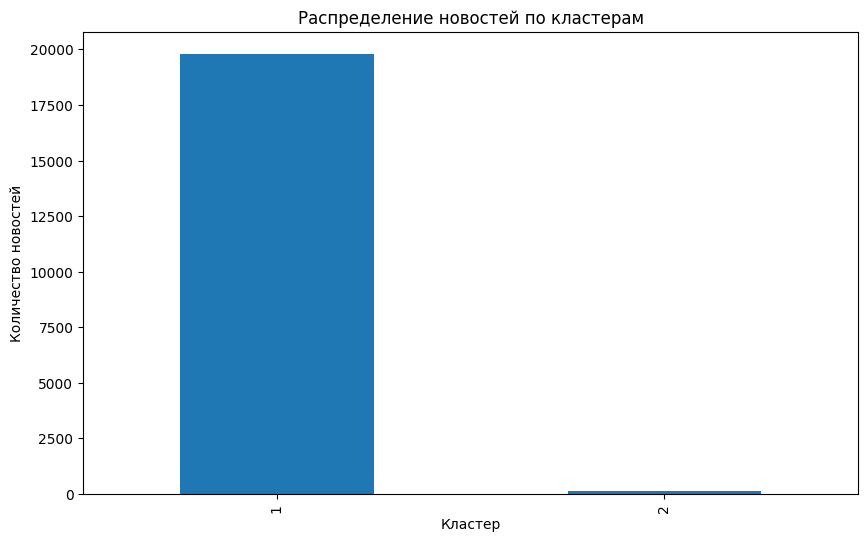

In [ ]:
plt.figure(figsize=(10, 6))
vk_news["cluster_idf_agg"].value_counts().plot(kind="bar")
plt.title("Распределение новостей по кластерам")
plt.xlabel("Кластер")
plt.ylabel("Количество новостей")
plt.show()

In [ ]:
get_top_keywords_agg(vectors_idf, cluster_labels_agg, labels=None, n_terms=15, original_data=vk_news)


Cluster 1
'', российские, новые, керлингистки, iphone, названы, мира, 2018, россию, санкций, чемпионате, лучшие, украина, антироссийских, сборную

Cluster 2
виктора, мараховского, колонка


In [ ]:
silhouette_idf_agg = silhouette_score(vectors_idf, agg_cluster_idf.labels_)
db_index_idf_agg = davies_bouldin_score(vectors_idf, agg_cluster_idf.labels_)
ch_index_idf_agg = calinski_harabasz_score(vectors_idf, agg_cluster_idf.labels_)

In [ ]:
print(silhouette_idf_agg)
print(db_index_idf_agg)
print(ch_index_idf_agg)

0.8541774551674124
0.38727221111157095
5212.073824251676


Значение silhouette score 0.854 является высоким. Значение Davies Bouldin Index 0.387 является низким, что указывает на хорошее качество кластеризации. При этом значение Calinski-Harabasz Score 5212.0738 указывает на среднее качество кластеризации.

# Results:

KMeans:

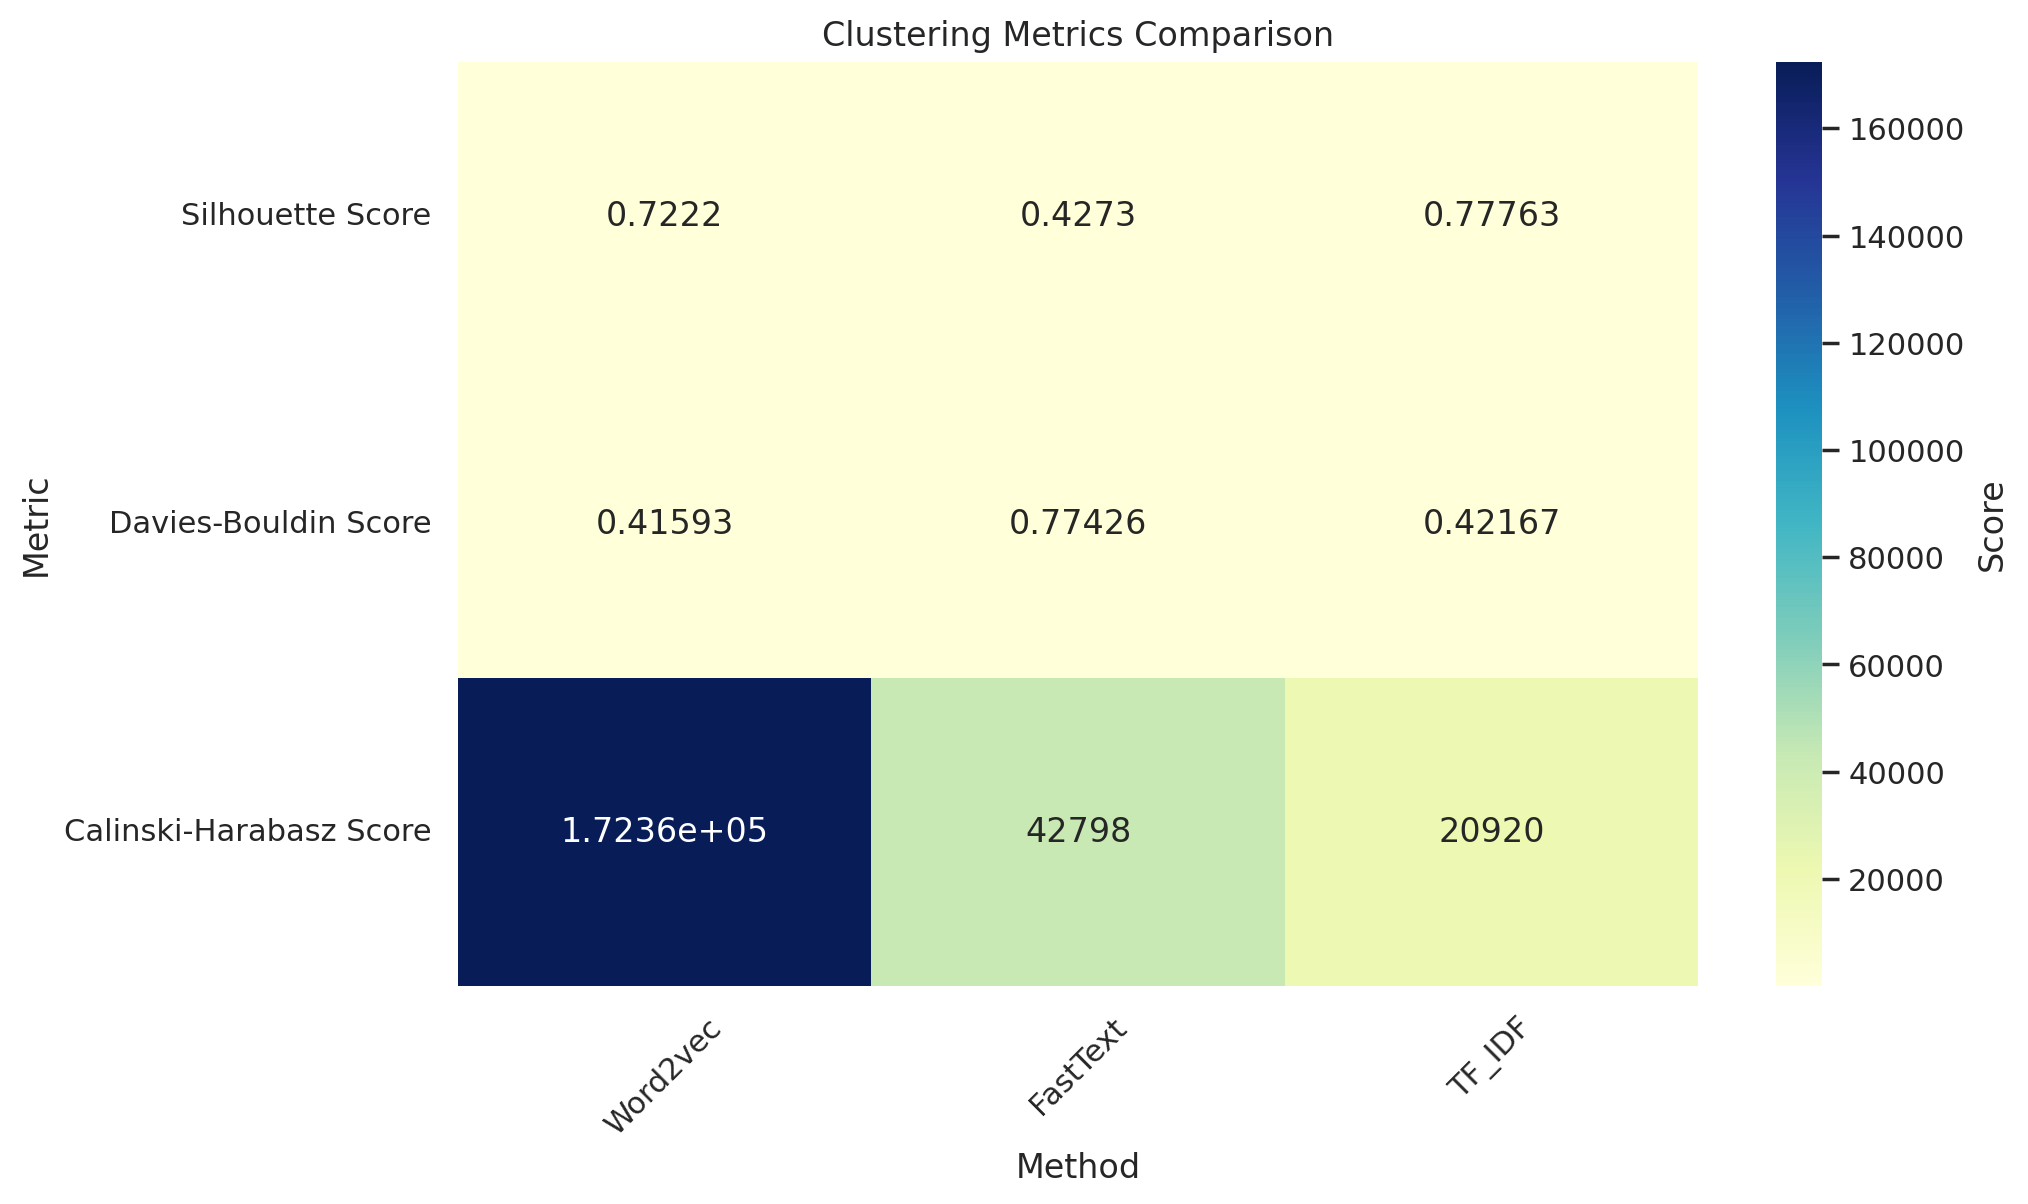

Agglomerative hierarchical clustering:

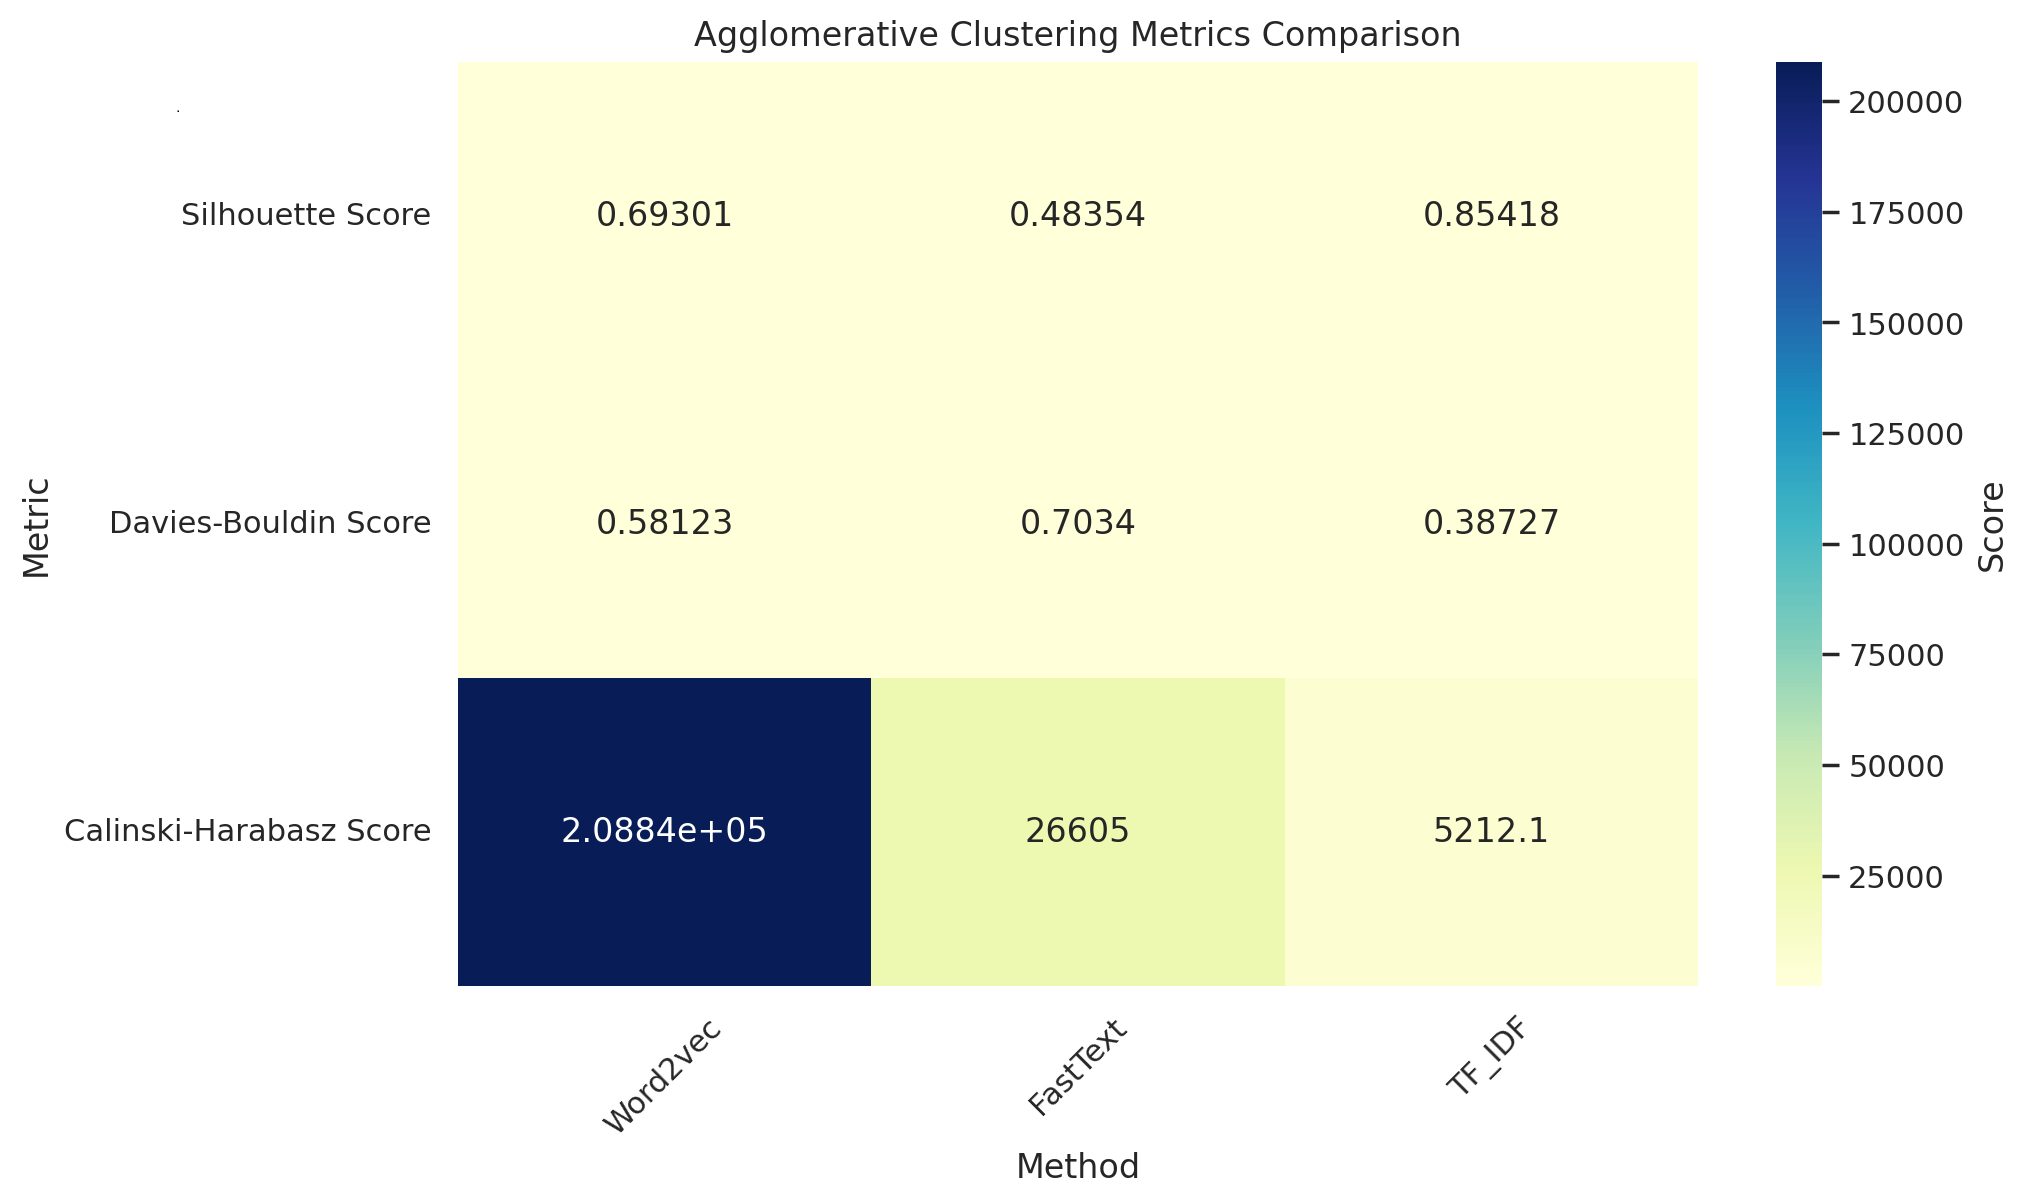